# Field Failure Data Analysis

## Import relevant module

In [1]:
# Uncomment lines below to install and enable progress bar in JupyterLab
# !pip install tqdm

# !jupyter nbextension enable --py widgetsnbextension
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [2]:
# Data Analysis
import pandas as pd
from scipy.optimize import curve_fit
import scipy.stats

# Data Visualization
from matplotlib import pyplot as plt

# Reliability
from reliability.Fitters import Fit_Everything, Fit_Weibull_3P
from reliability.Reliability_testing import KStest
from reliability.Distributions import Weibull_Distribution, Lognormal_Distribution, Exponential_Distribution
from reliability.Probability_plotting import plot_points
from statsmodels.distributions.empirical_distribution import ECDF

# Utilities
import os
import numpy as np
from tqdm import tnrange
from tqdm import tqdm_notebook as tqdmn

# %matplotlib notebook
# from IPython.core.interactiveshell import InteractiveShell

## Utility functions

In [3]:
def sensitivity_analysis(dataframe, c_wins, filepath):
    if(not os.path.isfile(filepath)):
        print('Creating file',filepath, 'this may take a while...\n')
        tuples = []

        for win in c_wins:
            tup = 1
            prev = int(dataframe.loc[0,'Timestamp'])

            for index in range(dataframe.shape[0]-1):
                succ = int(dataframe.loc[index+1,'Timestamp'])
                if  succ - prev >= win:
                    tup = tup + 1
                prev = succ
  
            tuples.append(tup)
        
        df_sens = pd.DataFrame(data = {'Window' : c_wins, 'Tuples' : tuples})
        df_sens.to_csv(filepath)

    else:
        print('File already exists!\n')
        df_sens = pd.read_csv(filepath, index_col = 0)
    
    return df_sens      

In [4]:
def tupling(dataframe, c_win, filepath):
    if(not os.path.isfile(filepath)):
        print('Creating file', filepath, 'this may take a while...\n')
        
        tup = 0
        prev = int(dataframe.loc[0,'Timestamp'])
        dataframe.loc[0,'Tuple'] = 0

        for index in range(dataframe.shape[0]-1):
            succ = int(dataframe.loc[index+1,'Timestamp'])
            if  succ - prev >= c_win:
                tup = tup + 1
            dataframe.loc[index+1,'Tuple'] = tup
            prev = succ
            
        dataframe.to_csv(filepath)

    else:
        print('File already exists!\n')
        dataframe = pd.read_csv(filepath, index_col = 0)
    
    return dataframe

In [5]:
def statistics(dataframe):
    df_stat = pd.DataFrame(columns=['# Entries', 'Start time', 'End time', 'Length', 'Density', 'Interarrival'])

    df_stat['# Entries'] = dataframe.groupby(by='Tuple').count()['Timestamp']
    df_stat['Start time'] =  dataframe.groupby(by='Tuple').min(numeric_only = True)['Timestamp']
    df_stat['End time'] =  dataframe.groupby(by='Tuple').max(numeric_only = True)['Timestamp']
    df_stat['Length'] =  df_stat['End time'] - df_stat['Start time']
    df_stat['Density'] = df_stat['# Entries'] / df_stat['Length']
    df_temp = pd.DataFrame(data = {'Start time' : [np.nan]})
    df_temp = df_temp.append(df_stat, ignore_index = True)
    df_stat['Interarrival'] = (df_stat['Start time'] - df_temp['End time']).dropna().astype(int)
        
    return df_stat

## Load Mercury data

In [6]:
df_mercury = pd.read_csv('Dataset/Mercury/MercuryErrorLog.txt', names = ['Timestamp', 'Node', 'Subsystem', 'Message'])

df_mercury.loc[:,'Node'] = df_mercury.loc[:,'Timestamp'].str.split(' ', n=3).str[1]
df_mercury.loc[:,'Subsystem'] = df_mercury.loc[:,'Timestamp'].str.split(' ', n=3).str[2]
df_mercury.loc[:,'Message'] = df_mercury.loc[:,'Timestamp'].str.split(' ', n=3).str[3]
df_mercury.loc[:,'Timestamp'] = df_mercury.loc[:,'Timestamp'].str.split(' ', n=3).str[0]

df_mercury.loc[df_mercury['Node'].str.contains('login'), 'Type'] = 'login'
df_mercury.loc[df_mercury['Node'].str.contains('c'), 'Type'] = 'computation'
df_mercury.loc[df_mercury['Node'].str.contains('s'), 'Type'] = 'storage'
df_mercury.loc[df_mercury['Node'].str.contains('master'), 'Type'] = 'master'

print('Log file has ' + str(df_mercury.shape[0]) + ' entries and ' + str(df_mercury.shape[1]) + ' columns.')
df_mercury.head()

Log file has 80854 entries and 5 columns.


,Timestamp,Node,Subsystem,Message,Type
0,1167637660,tg-c645,PRO,+BEGIN HARDWARE ERROR STATE AT CMC,computation
1,1167637660,tg-c645,PRO,Device Error Info Section,computation
2,1167637660,tg-c645,PRO,Error Map: x,computation
3,1167637720,tg-c645,PRO,+BEGIN HARDWARE ERROR STATE AT CMC,computation
4,1167637720,tg-c645,PRO,Device Error Info Section,computation


# System (Mercury)

## Data Manipulation

### Temporal coalescence

#### Sensitivity analysis

File already exists!



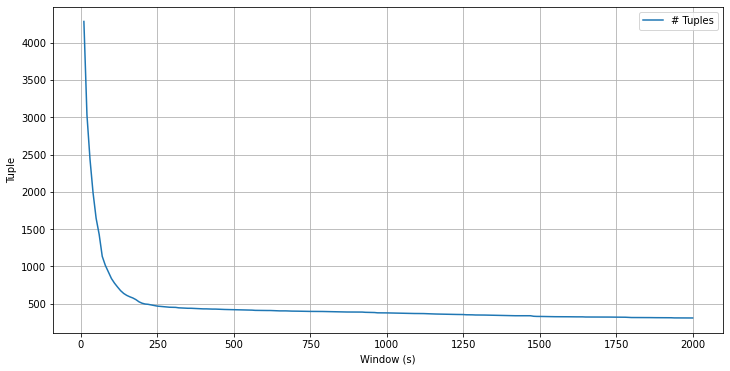

In [7]:
c_wins = np.delete(np.arange(0,2000,10), 0)

filepath = 'Dataset/Mercury/System/Mercury-Sensitivity.csv'

df_mercury_sensitivity = sensitivity_analysis(df_mercury, c_wins, filepath)

plt.figure(figsize=(12,6))
plt.plot(df_mercury_sensitivity['Window'],df_mercury_sensitivity['Tuples'], label = '# Tuples')
plt.xlabel('Window (s)')
plt.ylabel('Tuple')
plt.legend()
plt.grid()
plt.savefig("./Images/Mercury/Mercury_System_Sensitivity.svg", format = "svg")
plt.show()

#### Tupling

In [8]:
window = 250

filepath = 'Dataset/Mercury/System/Mercury-Data.csv'

df_mercury = tupling(df_mercury, window, filepath)
df_mercury = df_mercury.astype({'Timestamp' : 'int32', 'Tuple' : 'int32'})
df_mercury.tail()

File already exists!



,Timestamp,Node,Subsystem,Message,Tuple
80849,1174943008,tg-c196,I-O,hda: packet command error: error=x,467
80850,1174943068,tg-c128,I-O,hda: packet command error: error=x,467
80851,1174943068,tg-c128,I-O,hda: packet command error: error=x,467
80852,1174943925,tg-c196,NET,connection down,468
80853,1174943943,tg-c196,I-O,hda: packet command error: error=x,468


In [9]:
num_tuple = df_mercury.max(axis = 0).loc['Tuple'] + 1
print('Number of tuples: ', num_tuple)

Number of tuples:  469


In [10]:
df_sys_stat = statistics(df_mercury)
df_sys_stat.head()

,# Entries,Start time,End time,Length,Density,Interarrival
Tuple,,,,,,
0,6,1167637660,1167637720,60,0.100000,NaN
1,3,1167655228,1167655229,1,3.000000,17508.0
2,75,1167657137,1167657550,413,0.181598,1908.0
3,2,1167657941,1167657941,0,inf,391.0
4,27,1167658201,1167658456,255,0.105882,260.0


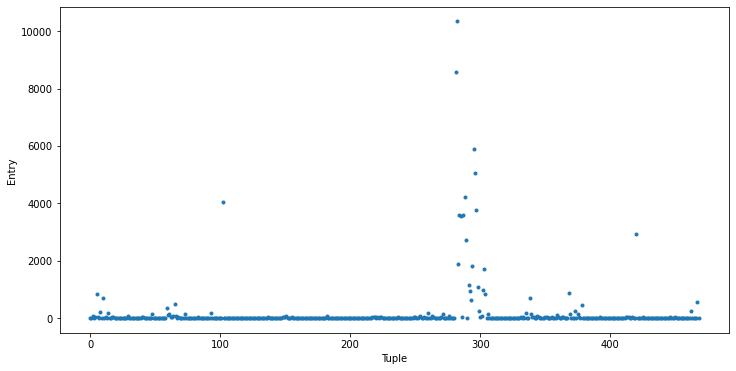

In [11]:
x = df_sys_stat.index
y = df_sys_stat['# Entries']

plt.figure(figsize=(12,6))
plt.scatter(x, y, marker = '.')
plt.xlabel('Tuple')
plt.ylabel('Entry')

plt.savefig("./Images/Mercury/Mercury_System_Scatter_Tuple_Entry.svg", format = "svg")
plt.show()

#### Bottleneck

In [12]:
start_tup = 281
end_tup = 306

df_bottleneck = df_mercury.loc[(df_mercury['Tuple']>=start_tup) & (df_mercury['Tuple']<=end_tup)]
df_bottleneck.head()

,Timestamp,Node,Subsystem,Message,Tuple
10162,1171321113,tg-c401,DEV,+BEGIN HARDWARE ERROR STATE AT CPE,281
10163,1171321113,tg-c401,DEV,+Platform PCI Component Error Info Section,281
10164,1171321113,tg-c401,DEV,Component Info: Vendor Id =x x,281
10165,1171321156,tg-c401,DEV,+BEGIN HARDWARE ERROR STATE AT CPE,281
10166,1171321156,tg-c401,DEV,+Platform PCI Component Error Info Section,281


In [13]:
df_bottleneck.groupby(by='Node').Timestamp.count().sort_values(ascending=False)

Node
tg-c401      62263
tg-login3      143
tg-login1      142
tg-s044        130
tg-master      102
tg-s176         13
tg-c027         12
tg-c106          7
tg-c781          6
tg-c407          4
tg-c735          3
tg-c669          3
tg-login2        2
tg-login4        2
tg-c128          2
tg-c894          1
tg-c685          1
Name: Timestamp, dtype: int64

In [14]:
df_bottleneck = df_bottleneck.loc[(df_bottleneck['Node']=='tg-c401')]
df_bottleneck.head()

,Timestamp,Node,Subsystem,Message,Tuple
10162,1171321113,tg-c401,DEV,+BEGIN HARDWARE ERROR STATE AT CPE,281
10163,1171321113,tg-c401,DEV,+Platform PCI Component Error Info Section,281
10164,1171321113,tg-c401,DEV,Component Info: Vendor Id =x x,281
10165,1171321156,tg-c401,DEV,+BEGIN HARDWARE ERROR STATE AT CPE,281
10166,1171321156,tg-c401,DEV,+Platform PCI Component Error Info Section,281


### Spatial coalescence

In [15]:
df_mercury.loc[df_mercury['Node'].str.contains('login'), 'Type'] = 'login'
df_mercury.loc[df_mercury['Node'].str.contains('c'), 'Type'] = 'computation'
df_mercury.loc[df_mercury['Node'].str.contains('s'), 'Type'] = 'storage'
df_mercury.loc[df_mercury['Node'].str.contains('master'), 'Type'] = 'master'

In [16]:
print('Number of nodes that generates error: ' + str(len(df_mercury['Node'].unique())))

Number of nodes that generates error: 53


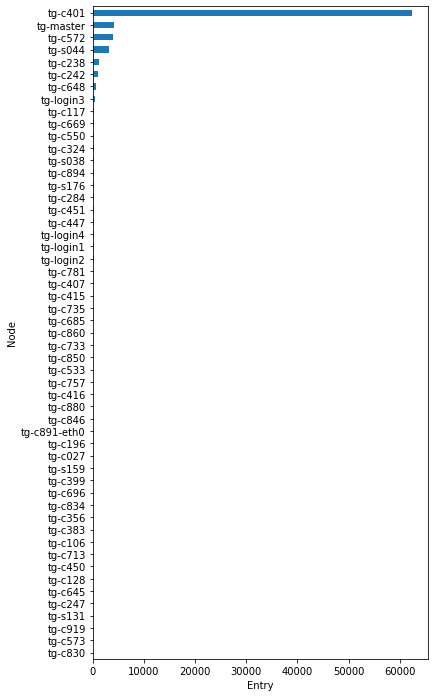

In [17]:
df_mercury.groupby(by='Node').Timestamp.count().sort_values().plot.barh('# Entries',figsize=(6,12))
plt.xlabel('Entry')

plt.savefig("./Images/Mercury/Mercury_System_Bar_Node.svg", format = "svg")
plt.show()

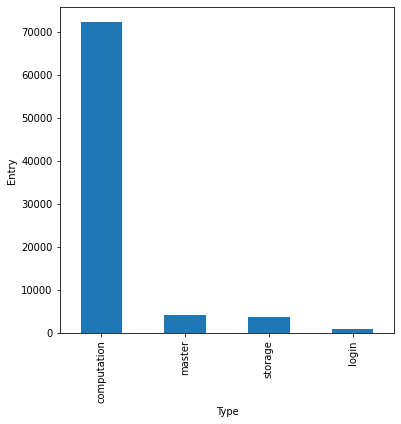

In [18]:
plt.figure(figsize=(6,6))
df_mercury.groupby(by=['Type']).Timestamp.count().sort_values(ascending = False).plot.bar()
plt.ylabel('Entry')

plt.savefig("./Images/Mercury/Mercury_System_Bar_Type.svg", format = "svg")
plt.show()

### Content-based coalescence

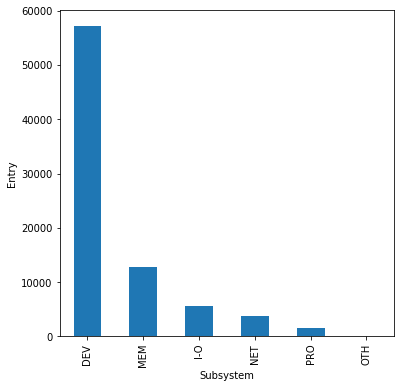

In [19]:
df_mercury.groupby(by=['Subsystem']).Timestamp.count().sort_values(ascending = False).plot.bar(figsize=(6,6))
plt.ylabel('Entry')
plt.savefig("./Images/Mercury/Mercury_System_Bar_Subsystem.svg", format = "svg")
plt.show()

In [20]:
# Fare altre osservazioni
df_mercury.groupby(by=['Subsystem','Type']).count()

Timestamp   Node  Message  Tuple
Subsystem Type                                         
DEV       computation      57037  57037    57037  57037
          master               3      3        3      3
          storage            208    208      208    208
I-O       computation        802    802      802    802
          login              820    820      820    820
          master             452    452      452    452
          storage           3473   3473     3473   3473
MEM       computation      12818  12818    12818  12818
          master               1      1        1      1
NET       computation         56     56       56     56
          login                3      3        3      3
          master            3639   3639     3639   3639
          storage              4      4        4      4
OTH       computation         17     17       17     17
          master               3      3        3      3
          storage             14     14       14     14
PRO       computation       1504   1504     1504   1504

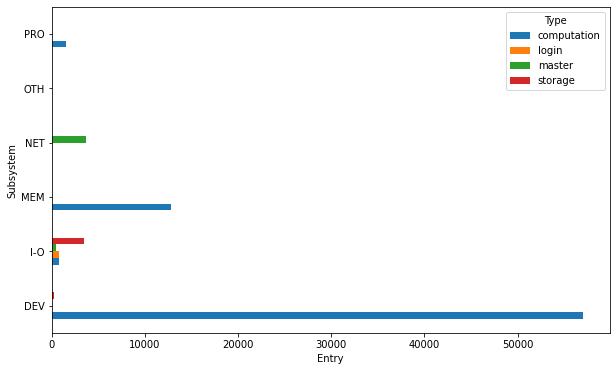

In [21]:
df_mercury.groupby(by=['Subsystem','Type']).Timestamp.count().unstack(1).plot.barh(figsize=(10,6))
plt.xlabel('Entry')
plt.savefig("./Images/Mercury/Mercury_System_Bar_Subsys_Type.svg", format = "svg")

### Truncation analysis

In [22]:
q = df_sys_stat['Interarrival'].quantile(q=0.1)
print("0.1 quantile: " + str(q))

0.1 quantile: 491.90000000000003


In [23]:
df_trunc = df_sys_stat.loc[df_sys_stat['Interarrival'] <= q]
df_trunc.head()

,# Entries,Start time,End time,Length,Density,Interarrival
Tuple,,,,,,
3,2,1167657941,1167657941,0,inf,391.0
4,27,1167658201,1167658456,255,0.105882,260.0
5,825,1167658913,1167665307,6394,0.129027,457.0
6,22,1167665787,1167665982,195,0.112821,480.0
9,17,1167669001,1167669463,462,0.036797,377.0


In [24]:
num_trunc = df_trunc.shape[0]
perc_trunc = (num_trunc/num_tuple)*100

print('Estimate number of truncations:', num_trunc)
print('Estimate percentage of truncations:', perc_trunc)

Estimate number of truncations: 47
Estimate percentage of truncations: 10.021321961620469


In [25]:
df_group = df_mercury.groupby(by=['Tuple','Node']).count()
df_group.tail()

Timestamp  Subsystem  Message  Type
Tuple Node                                          
466   tg-master          4          4        4     4
467   tg-c128            2          2        2     2
      tg-c196            2          2        2     2
      tg-master        558        558      558   558
468   tg-c196            2          2        2     2

In [26]:
df_group = df_group.reset_index(level = 1)

truncated = 0
for tup in df_trunc.index:

    df_tup = df_group.loc[df_group.index == tup]    
    node = df_tup.loc[df_tup['Timestamp'] == df_tup.max()['Timestamp'], 'Node'].item()
    
    df_tup_prec = df_group.loc[df_group.index == tup-1]
    node_prec = df_tup_prec.loc[df_tup_prec['Timestamp'] == df_tup_prec.max()['Timestamp'], 'Node'].item()
    
    if node == node_prec:
        truncated = truncated +1

In [27]:
perc_trunc = (truncated/num_tuple)*100

print('Estimate number of truncations:', truncated)
print('Estimate percentage of truncations:', perc_trunc)

Estimate number of truncations: 38
Estimate percentage of truncations: 8.102345415778252


### Collision analysis

In [28]:
collided = 0
for tup in df_group.index.unique():
    if df_group.loc[df_group.index == tup].shape[0] > 1:
        collided = collided + 1

In [29]:
perc_coll = (collided/num_tuple)*100

print('Estimate number of collisions:', collided)
print('Estimate percentage of collisions: ', perc_coll)

Estimate number of collisions: 51
Estimate percentage of collisions:  10.874200426439232


## Data Analysis

### Empirical time to failure distribution

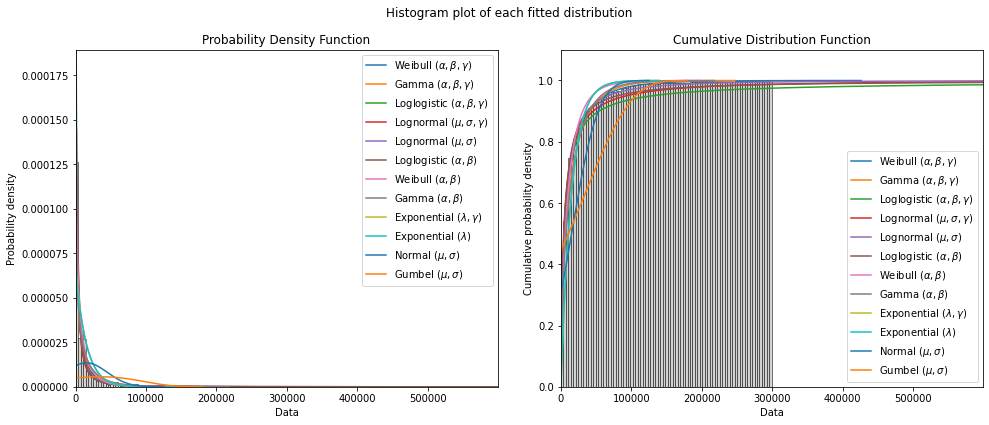

The best fitting distribution was Weibull_3P which had parameters [9.30684336e+03 5.80580908e-01 2.52999900e+02]


In [30]:
data = df_sys_stat['Interarrival'].dropna().to_numpy()

results = Fit_Everything(failures=data, show_PP_plot = False, show_probability_plot = False, print_results = False, show_histogram_plot = True)
print('The best fitting distribution was', results.best_distribution_name, 'which had parameters', results.best_distribution.parameters)

In [31]:
results.results

,Alpha,Beta,Gamma,Mu,Sigma,Lambda,AICc,BIC,AD
Distribution,,,,,,,,,
Weibull_3P,9306.84,0.580581,253,,,,9621.937663,9634.331344,0.781407
Gamma_3P,33518.5,0.446207,253,,,,9648.930935,9661.324616,3.413044
Loglogistic_3P,4136.65,0.854912,253,,,,9664.960542,9677.354223,2.939155
Lognormal_3P,,,235.79,8.23439,1.94723,,9665.315113,9677.708794,3.121882
Lognormal_2P,,,,8.46357,1.61232,,9701.159540,9709.430670,2.680266
Loglogistic_2P,4738.95,1.04178,,,,,9732.209731,9740.480861,3.557992
Weibull_2P,10213.1,0.748365,,,,,9776.423817,9784.694947,6.794443
Gamma_2P,28241.9,0.538533,,,,,9797.951246,9806.222376,9.079964
Exponential_2P,,,252.999,,,6.68621e-05,9937.680059,9945.951189,78.956474


Results from Fit_Weibull_3P (95% CI):
           Point Estimate  Standard Error     Lower CI      Upper CI
Parameter                                                           
Alpha         9306.843358      781.146430  7895.123887  10970.991022
Beta             0.580581        0.020628     0.541527      0.622452
Gamma          252.999900        0.000154   252.999598    253.000202
Log-Likelihood: -4807.94296952023 



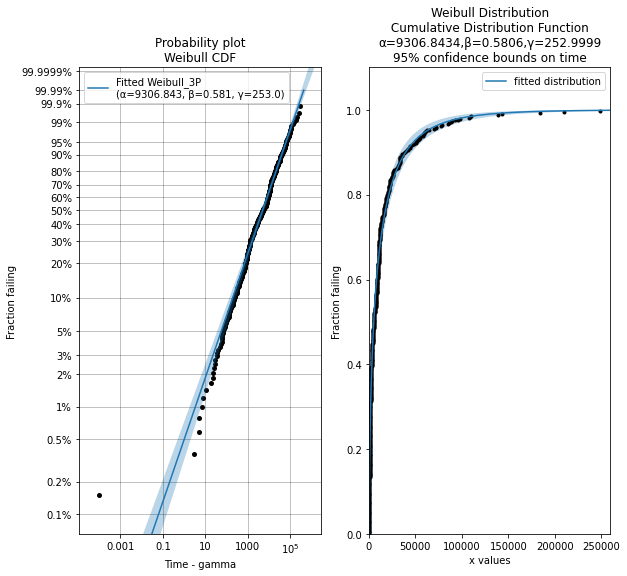

In [32]:
alpha = results.results.loc['Weibull_3P','Alpha']
beta = results.results.loc['Weibull_3P','Beta']
gamma = results.results.loc['Weibull_3P','Gamma']

plt.subplot(121)
fit = Fit_Weibull_3P(failures=data)
plt.subplot(122)
fit.distribution.CDF(label='fitted distribution')
plot_points(failures=data, func='CDF')

plt.legend()
plt.show()

Kolmogorov-Smirnov statistic: 0.06895067351802397
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Lognormal Distribution (μ=8.4636,σ=1.6123)


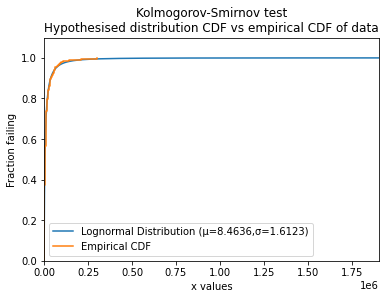

Kolmogorov-Smirnov statistic: 0.09005395535836147
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Weibull Distribution (α=10213.145,β=0.7484)


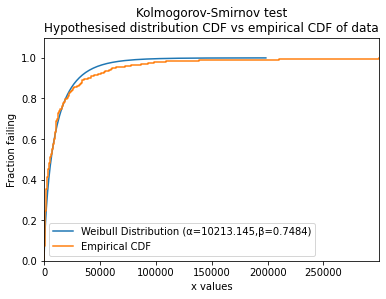

Kolmogorov-Smirnov statistic: 0.23625291490398848
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Exponential Distribution (λ=6.575e-05)


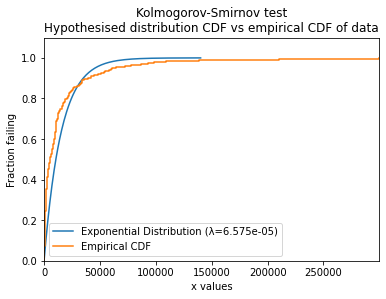

In [33]:
# dist = Weibull_Distribution(alpha=alpha, beta=beta, gamma=gamma)

# result = KStest(distribution = dist, data = df_sys_stat['Interarrival'].to_numpy(), significance = 0.05)

lognormal = Lognormal_Distribution(mu=results.results.loc['Lognormal_2P','Mu'], sigma=results.results.loc['Lognormal_2P','Sigma'])
weibull = Weibull_Distribution(alpha=results.results.loc['Weibull_2P','Alpha'], beta=results.results.loc['Weibull_2P','Beta'])
exponential = Exponential_Distribution(Lambda=results.results.loc['Exponential_1P','Lambda'])
distributions = [lognormal, weibull, exponential]

data = df_sys_stat['Interarrival'].to_numpy()

for dist in distributions:
    result = KStest(distribution = dist, data = data, significance = 0.05)

### Empirical reliability

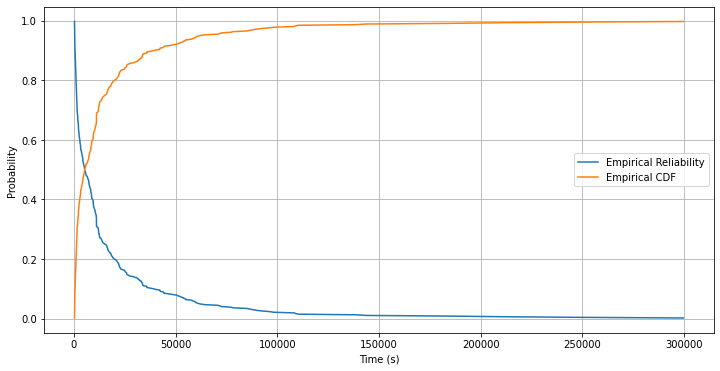

In [34]:
ecdf = ECDF(data)

plt.figure(figsize=(12,6))
    
plt.plot(ecdf.x, 1-ecdf.y, label = 'Empirical Reliability')
plt.plot(ecdf.x, ecdf.y, label = 'Empirical CDF')

plt.xlabel('Time (s)')
plt.ylabel('Probability')
plt.legend()
plt.grid()
plt.savefig("./Images/Mercury/Mercury_System_Emp_Reliability.svg", format = "svg")
plt.show()

tempo = pd.DataFrame(data = ecdf.x, columns=['tempo'])
rel = pd.DataFrame(data = 1-ecdf.y, columns=['reliability'])
tempo.to_csv('./Matlab/tempo_Mercury_system.csv', index=False)
rel.to_csv('./Matlab/reliability_Mercury_system.csv', index=False)


tempi_int = pd.DataFrame(df_sys_stat['Interarrival'].dropna().to_numpy(), columns=['tempi interarrivo'])
tempi_int.to_csv('./Matlab/tempi_int.csv', index=False)

### General Analysis

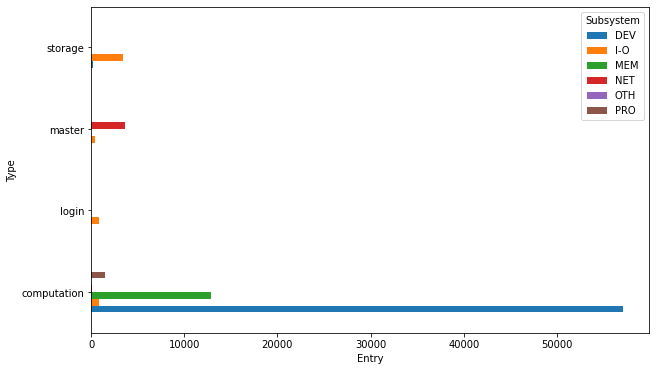

In [35]:
df_mercury.groupby(by=['Subsystem','Type']).Timestamp.count().unstack(0).plot.barh(figsize=(10,6))
plt.xlabel('Entry')
plt.savefig("./Images/Mercury/Mercury_System_Bar_Type_Subsys.svg", format = "svg")
plt.show()

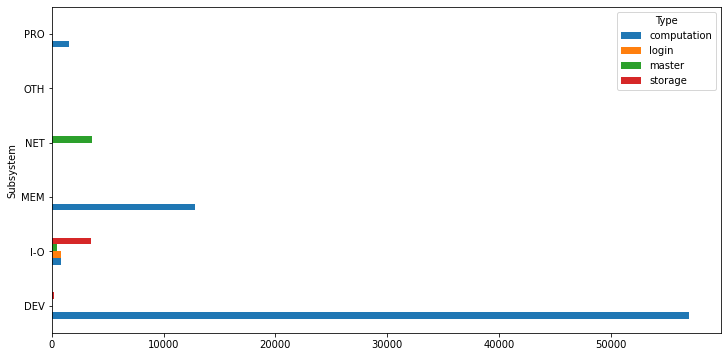

In [36]:
df_mercury.groupby(by=['Subsystem','Type']).Timestamp.count().unstack(1).plot.barh(figsize=(12,6))
plt.show()

In [37]:
print('Distinct error messages:', df_mercury.groupby(by='Message').count().shape[0])

Distinct error messages: 48


In [38]:
df_mercury.groupby(by='Message').count().sort_values(by='Timestamp', ascending=False).head(10).drop(columns=df_mercury.groupby(by='Message').count().columns[1:5])

,Timestamp
Message,
Component Info: Vendor Id =x x,25712
Physical Address x,12746
+Platform PCI Component Error Info Section,8221
+BEGIN HARDWARE ERROR STATE AT CPE,7498
+ Platform Specific Error Detail:,5929
+Platform Specific Error Info Section,5812
+END HARDWARE ERROR STATE AT CPE,4021
setting node state to down,3635
error: dev x:x,2944


In [39]:
df_mercury.groupby(by=['Subsystem','Message']).count().drop(columns=['Node', 'Type', 'Tuple']).head()

Timestamp
Subsystem Message                                              
DEV       + Platform Specific Error Detail:                5929
          +BEGIN HARDWARE ERROR STATE AT CPE               7498
          +END HARDWARE ERROR STATE AT CPE                 4021
          +Platform PCI Component Error Info Section       8221
          +Platform Specific Error Info Section            5812

In [40]:
pd.set_option('display.max_rows', None)
df_mercury.groupby(by=['Type','Message']).count().drop(columns=['Node', 'Subsystem', 'Tuple']).head()

Timestamp
Type        Message                                      
computation + Mem Error Detail:                        72
            + Platform Specific Error Detail:        5928
            +BEGIN HARDWARE ERROR STATE AT CMC        425
            +BEGIN HARDWARE ERROR STATE AT CPE       7419
            +END HARDWARE ERROR STATE AT CMC          252

In [41]:
pd.reset_option('display.max_rows')

# Subsystems

In [42]:
subsystems = df_mercury.groupby(by=['Subsystem']).Timestamp.count().sort_values(ascending = False).drop('OTH')

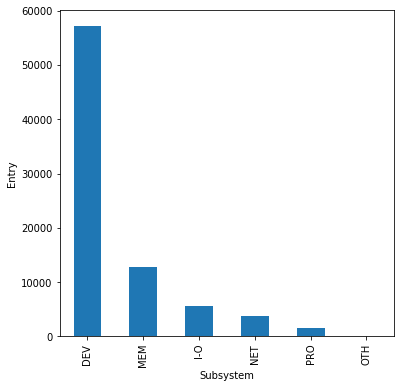

In [43]:
df_mercury.groupby(by=['Subsystem']).Timestamp.count().sort_values(ascending = False).plot.bar(figsize=(6,6))
plt.ylabel('Entry')
plt.show()

## Data Manipulation

### Temporal coalescence

#### Sensitivity analysis

In [44]:
c_wins = np.delete(np.arange(0,500,1), 0)

for subsys in subsystems.index:
    df_temp = df_mercury.loc[df_mercury['Subsystem'] == subsys]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = 'Dataset/Mercury/Subsystems/Mercury-' + subsys + '-Sensitivity.csv'
    
    sensitivity_analysis(df_temp, c_wins, filepath)

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!



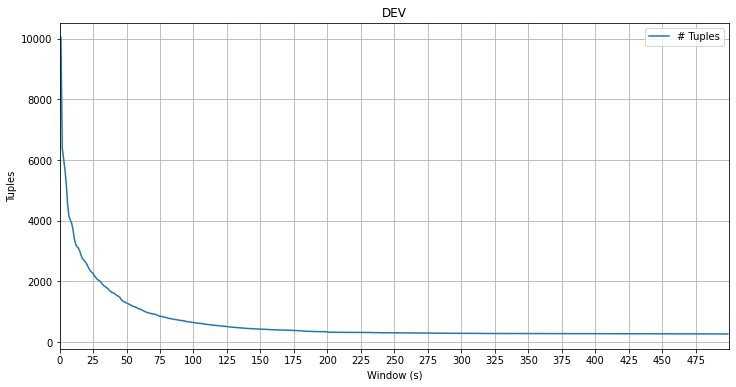

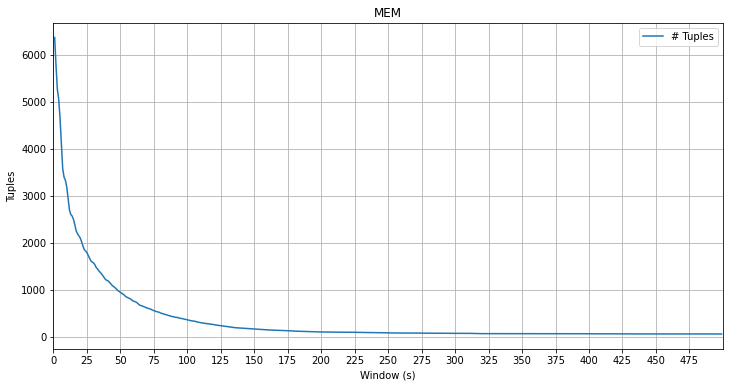

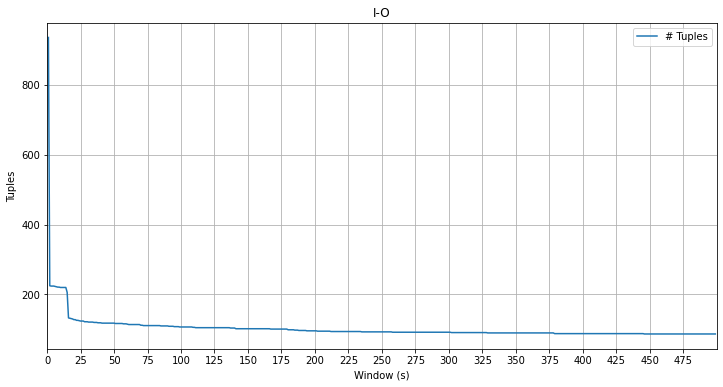

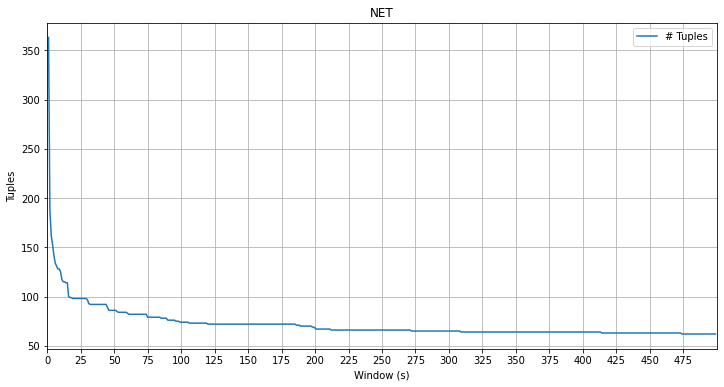

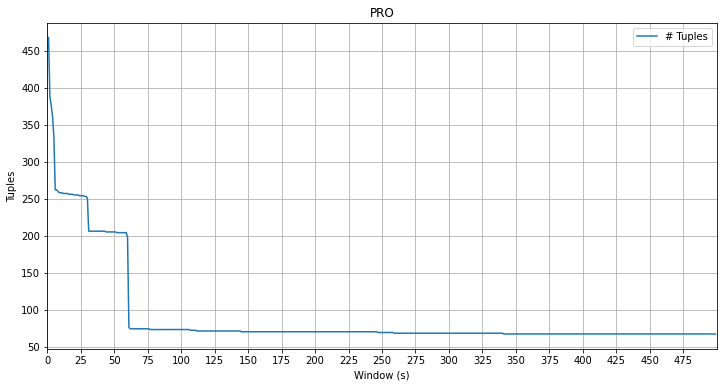

In [45]:
for subsys in subsystems.index:
    filepath = 'Dataset/Mercury/Subsystems/Mercury-' + subsys + '-Sensitivity.csv'
    
    df_temp_sensitivity = pd.read_csv(filepath, index_col = 0)
    
    x = df_temp_sensitivity['Window']
    y = df_temp_sensitivity['Tuples']
    
    plt.figure(figsize=(12,6))
    plt.plot(x, y, label = '# Tuples')
    plt.title(subsys)
    plt.xlim(0,500)
    plt.xticks(np.arange(0, 500, step = 25))
    plt.xlabel('Window (s)')
    plt.ylabel('Tuples')
    plt.legend()
    plt.grid()
    plt.savefig("./Images/Mercury/Mercury_Subsystem_Sensitivity_" + subsys + ".svg", format = "svg")
    plt.show()

In [46]:
win_dict = {'DEV' : 200,
            'MEM' : 200,
            'I-O' : 100,
            'NET' : 100,
            'PRO' : 100}
print('Selected coalescence windows:', win_dict)

Selected coalescence windows: {'DEV': 200, 'MEM': 200, 'I-O': 100, 'NET': 100, 'PRO': 100}


#### Tupling

In [47]:
dict_df_cat_stat = {}
dict_cat_num_tup = {}

for subsys in subsystems.index:
    df_temp = df_mercury.loc[df_mercury['Subsystem'] == subsys]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = 'Dataset/Mercury/Subsystems/Mercury-' + subsys + '-Data.csv'
    
    df_tupling = tupling(df_temp, win_dict[subsys], filepath)
    num_tup = df_tupling.max(axis = 0).loc['Tuple'] + 1
    dict_cat_num_tup[subsys] = num_tup
    
    df_stat = statistics(df_tupling)
    dict_df_cat_stat[subsys] = df_stat

print('Number of tuples:', dict_cat_num_tup)

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!

Number of tuples: {'DEV': 334, 'MEM': 105, 'I-O': 107, 'NET': 74, 'PRO': 73}


## Data Analysis

### Empirical time to failure distribution

Subsystem: DEV


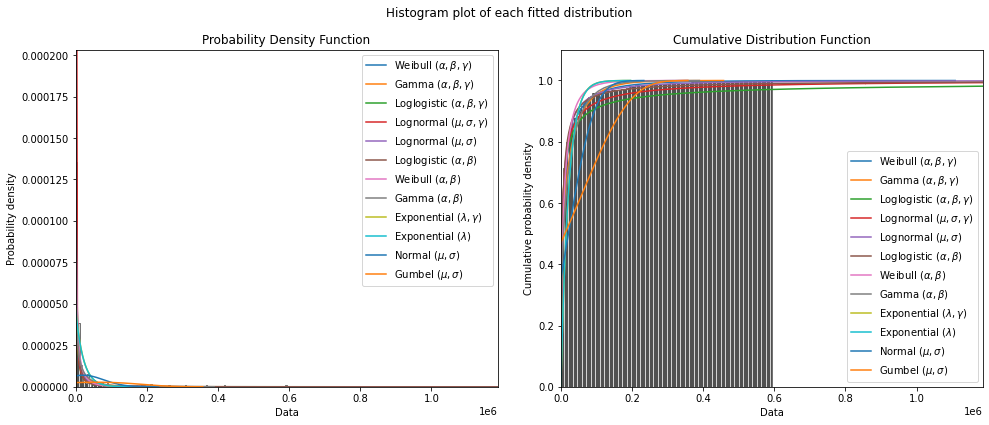

The best fitting distribution was Weibull_3P which had parameters [8.40701430e+03 4.54859607e-01 1.99999900e+02]
Kolmogorov-Smirnov statistic: 0.09032239120752028
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Lognormal Distribution (μ=8.2783,σ=1.9026)


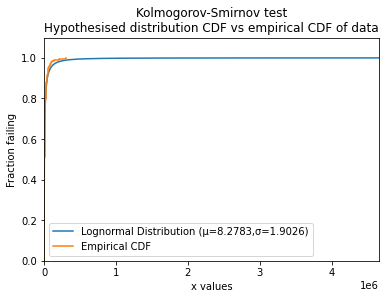

Kolmogorov-Smirnov statistic: 0.09759495708083206
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Weibull Distribution (α=9932.5392,β=0.6201)


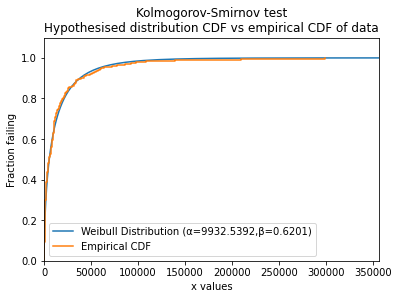

Kolmogorov-Smirnov statistic: 0.28852933510089557
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Exponential Distribution (λ=4.681e-05)


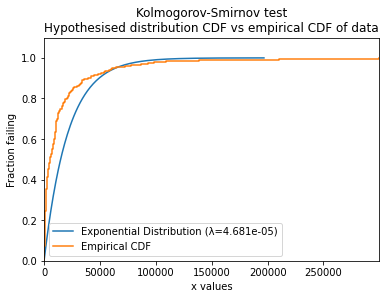

Subsystem: MEM


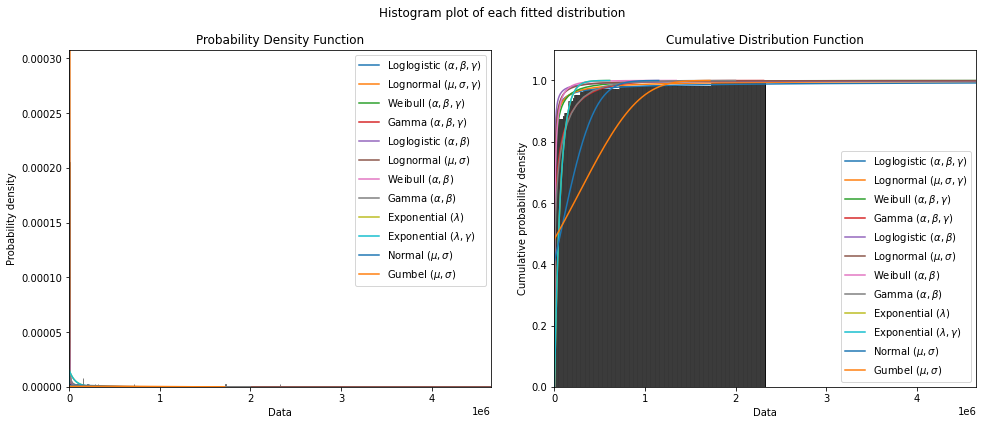

The best fitting distribution was Loglogistic_3P which had parameters [6.72523964e+02 5.46970278e-01 1.99999900e+02]
Kolmogorov-Smirnov statistic: 0.21741186460516074
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Lognormal Distribution (μ=7.5009,σ=2.3583)


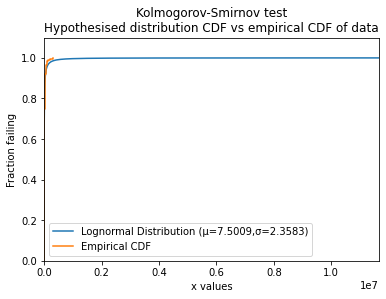

Kolmogorov-Smirnov statistic: 0.21890991056254483
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Weibull Distribution (α=6959.8853,β=0.4218)


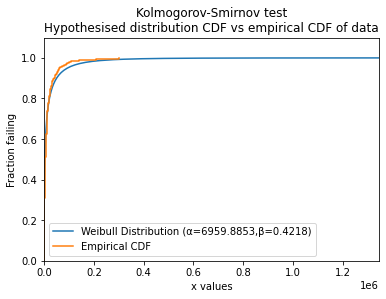

Kolmogorov-Smirnov statistic: 0.5533557902931788
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Exponential Distribution (λ=1.51e-05)


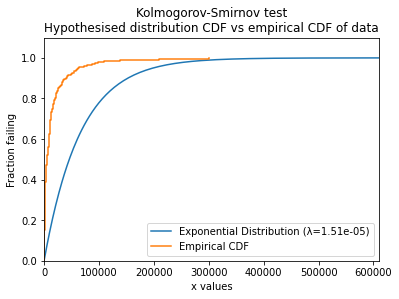

Subsystem: I-O


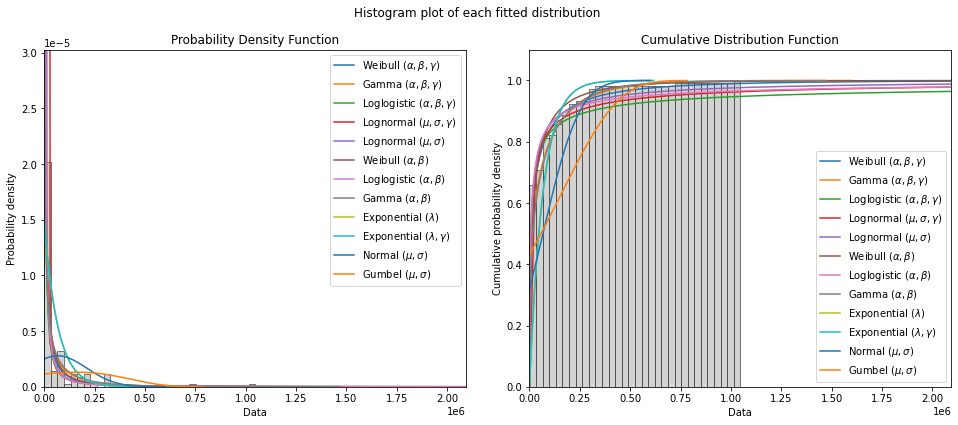

The best fitting distribution was Weibull_3P which had parameters [2.20669245e+04 3.97370861e-01 1.07999900e+02]
Kolmogorov-Smirnov statistic: 0.15658875498308056
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Lognormal Distribution (μ=8.8755,σ=2.5078)


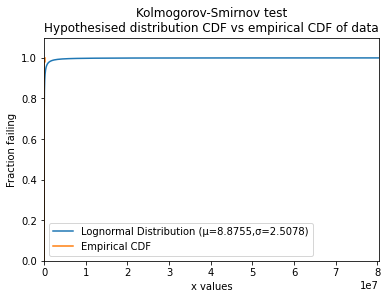

Kolmogorov-Smirnov statistic: 0.21020429057527523
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Weibull Distribution (α=24182.5174,β=0.4667)


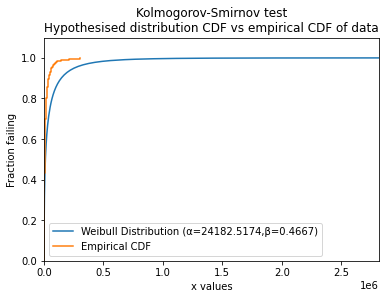

Kolmogorov-Smirnov statistic: 0.5550689619996962
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Exponential Distribution (λ=1.494e-05)


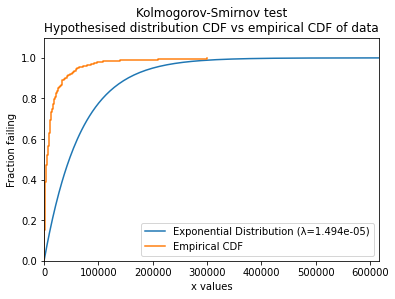

Subsystem: NET


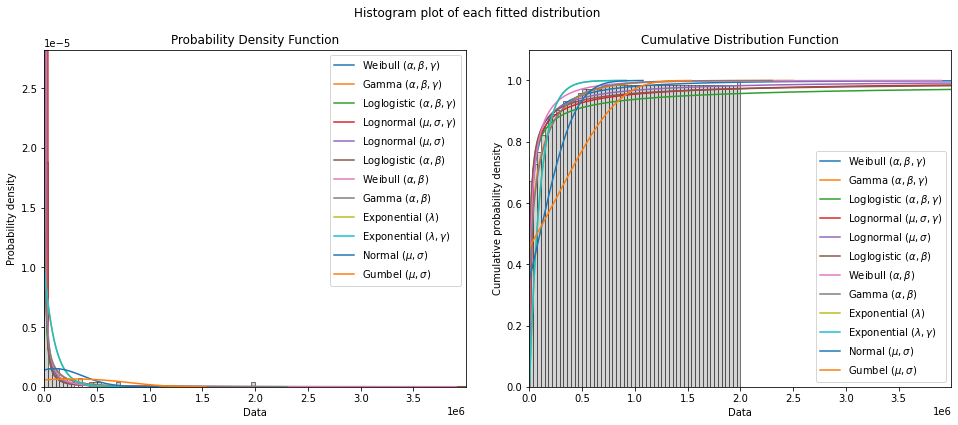

The best fitting distribution was Weibull_3P which had parameters [2.84207649e+04 3.86732768e-01 1.04999900e+02]
Kolmogorov-Smirnov statistic: 0.18923065888928603
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Lognormal Distribution (μ=9.0959,σ=2.5487)


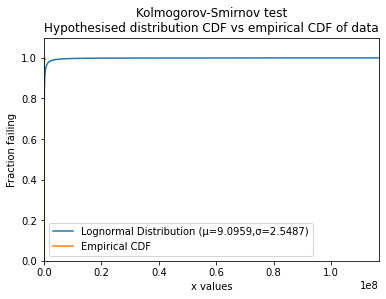

Kolmogorov-Smirnov statistic: 0.24977542777732875
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Weibull Distribution (α=30638.0118,β=0.458)


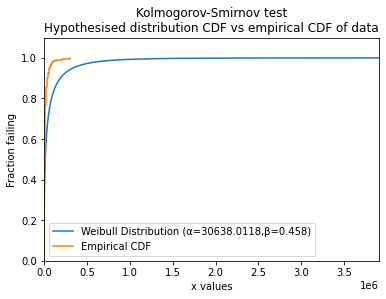

Kolmogorov-Smirnov statistic: 0.6278252588331052
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Exponential Distribution (λ=1.002e-05)


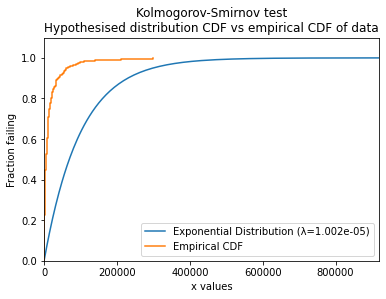

Subsystem: PRO


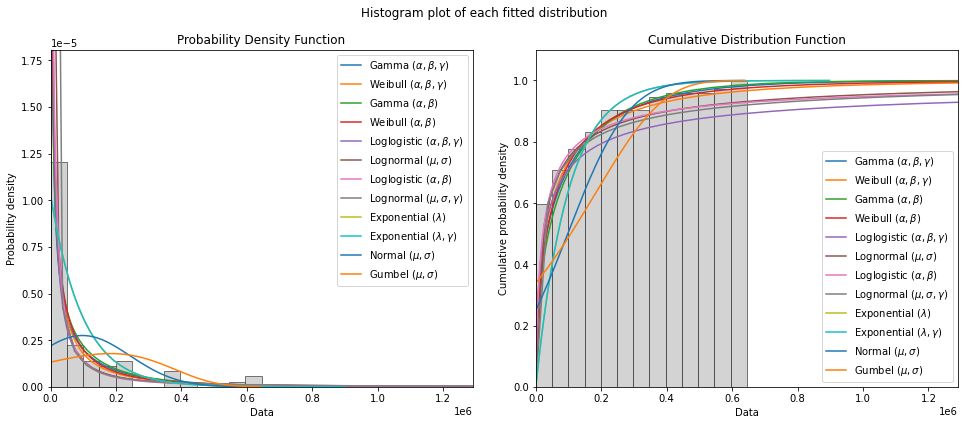

The best fitting distribution was Gamma_3P which had parameters [2.62583554e+05 3.70884964e-01 1.05999900e+02]
Kolmogorov-Smirnov statistic: 0.3231592393571152
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Lognormal Distribution (μ=9.9828,σ=2.2834)


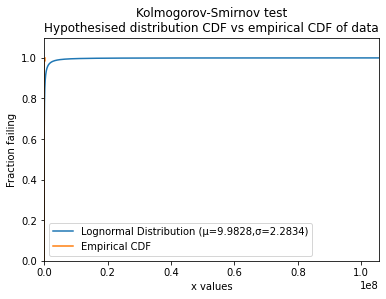

Kolmogorov-Smirnov statistic: 0.4011482197297537
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Weibull Distribution (α=63016.7584,β=0.5636)


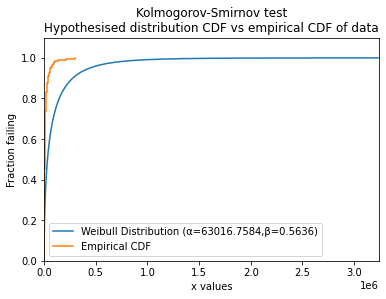

Kolmogorov-Smirnov statistic: 0.6235718778761199
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Exponential Distribution (λ=1.026e-05)


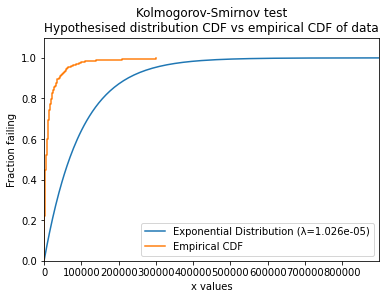

In [48]:
for subsys in subsystems.index:
    print('Subsystem:', subsys)
    data = dict_df_cat_stat[subsys]['Interarrival'].dropna().to_numpy()
    
    try:
        results = Fit_Everything(failures=data, show_PP_plot = False, show_probability_plot = False, print_results = False, show_histogram_plot = True)
        print('The best fitting distribution was', results.best_distribution_name, 'which had parameters', results.best_distribution.parameters)
        
        lognormal = Lognormal_Distribution(mu=results.results.loc['Lognormal_2P','Mu'], sigma=results.results.loc['Lognormal_2P','Sigma'])
        weibull = Weibull_Distribution(alpha=results.results.loc['Weibull_2P','Alpha'], beta=results.results.loc['Weibull_2P','Beta'])
        exponential = Exponential_Distribution(Lambda=results.results.loc['Exponential_1P','Lambda'])
        distributions = [lognormal, weibull, exponential]

        data = df_sys_stat['Interarrival'].to_numpy()

        for dist in distributions:
            result = KStest(distribution = dist, data = data, significance = 0.05)
#         alpha = results.results.loc['Lognormal_3P','Gamma']
#         beta = results.results.loc['Lognormal_3P','Mu']
#         gamma = results.results.loc['Lognormal_3P','Sigma']
#         dist = Lognormal_Distribution(gamma=alpha, mu=beta, sigma=gamma)

#         result = KStest(distribution = dist, data = dict_df_cat_stat[subsys]['Interarrival'].dropna().to_numpy(), significance = 0.05)
        
    except Exception as e:
        print('Exception:', e)

### Empirical reliability

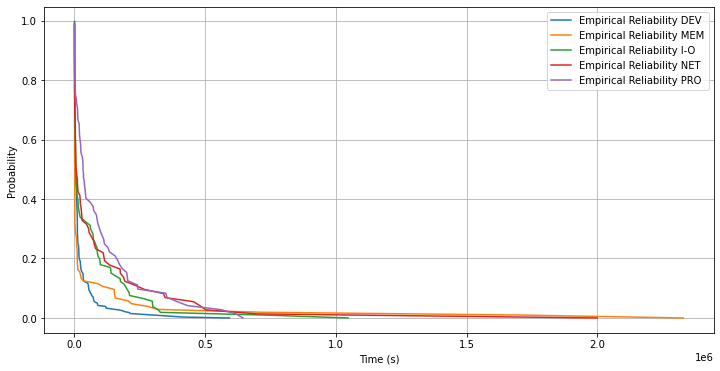

In [49]:
plt.figure(figsize=(12,6))
    
for subsys in subsystems.index:
    
    ecdf = ECDF(dict_df_cat_stat[subsys]['Interarrival'].dropna())

    plt.plot(ecdf.x, 1-ecdf.y, label = 'Empirical Reliability ' + str(subsys))
    plt.xlabel('Time (s)')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid()
    plt.savefig("./Images/Mercury/Mercury_Subsystem_Emp_Reliability.svg", format = "svg")

# Types

In [50]:
types = df_mercury.groupby(by=['Type']).Timestamp.count().sort_values(ascending = False)

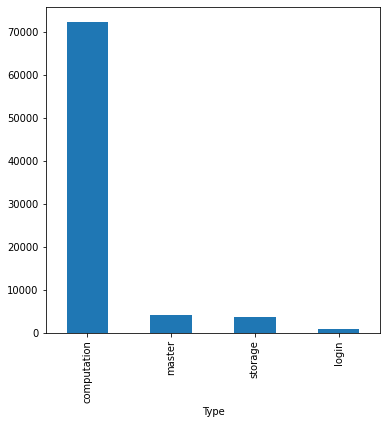

In [51]:
df_mercury.groupby(by=['Type']).Timestamp.count().sort_values(ascending = False).plot.bar(figsize=(6,6))
plt.show()

## Data Manipulation

### Temporal coalescence

#### Sensitivity analysis

In [52]:
c_wins = np.delete(np.arange(0,500,1), 0)

for t in types.index:
    df_temp = df_mercury.loc[df_mercury['Type'] == t]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = 'Dataset/Mercury/Types/Mercury-' + t + '-Sensitivity.csv'
    
    sensitivity_analysis(df_temp, c_wins, filepath)

File already exists!

File already exists!

File already exists!

File already exists!



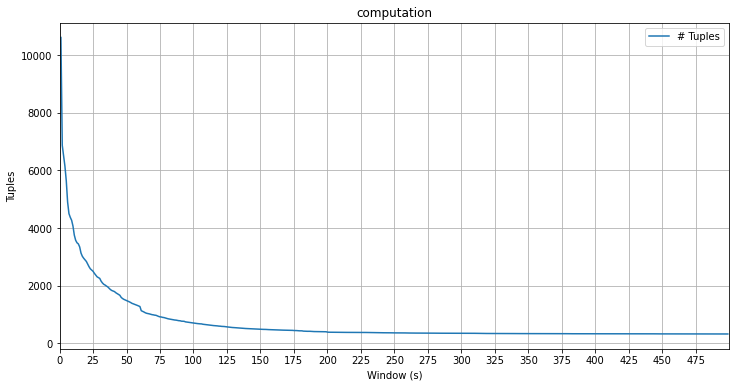

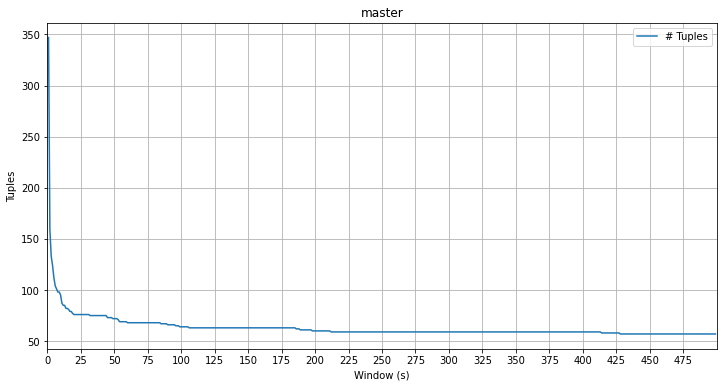

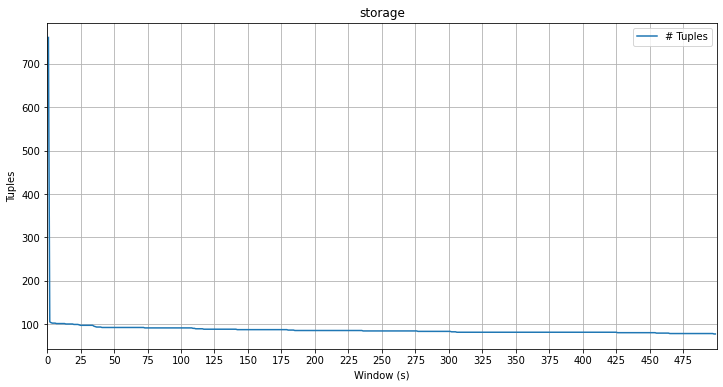

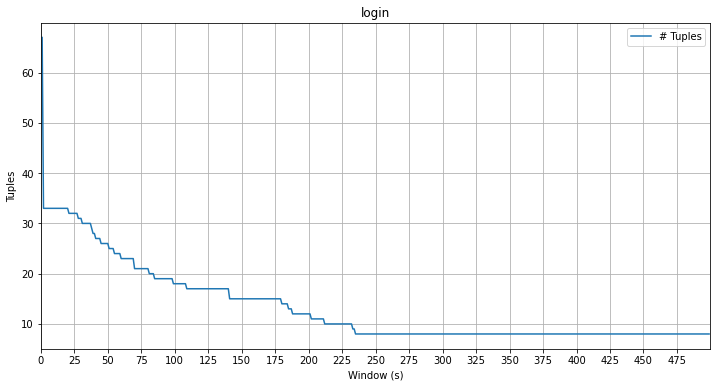

In [53]:
for t in types.index:
    filepath = 'Dataset/Mercury/Types/Mercury-' + t + '-Sensitivity.csv'
    
    df_temp_sensitivity = pd.read_csv(filepath, index_col = 0)
    
    x = df_temp_sensitivity['Window']
    y = df_temp_sensitivity['Tuples']
    
    plt.figure(figsize=(12,6))
    plt.plot(x, y, label = '# Tuples')
    plt.title(t)
    plt.xlim(0,500)
    plt.xticks(np.arange(0, 500, step = 25))
    plt.xlabel('Window (s)')
    plt.ylabel('Tuples')
    plt.legend()
    plt.grid()
    plt.savefig("./Images/Mercury/Mercury_Type_Sensitivity_" + t + ".svg", format = "svg")

In [54]:
win_dict = {'computation' : 200,
            'master' : 150,
            'storage' : 100,
            'login' : 300}
print('Selected coalescence windows:', win_dict)

Selected coalescence windows: {'computation': 200, 'master': 150, 'storage': 100, 'login': 300}


#### Tupling

In [55]:
dict_df_type_stat = {}
dict_type_num_tup = {}

for t in types.index:
    df_temp = df_mercury.loc[df_mercury['Type'] == t]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = 'Dataset/Mercury/Types/Mercury-' + t + '-Data.csv'
    
    df_tupling = tupling(df_temp, win_dict[t], filepath)
    num_tup = df_tupling.max(axis = 0).loc['Tuple'] + 1
    dict_type_num_tup[t] = num_tup
    
    df_stat = statistics(df_tupling)
    dict_df_type_stat[t] = df_stat

print('Number of tuples:', dict_type_num_tup)

File already exists!

File already exists!

File already exists!

File already exists!

Number of tuples: {'computation': 382, 'master': 63, 'storage': 91, 'login': 8}


## Data Analysis

### Empirical time to failure distribution

Type: computation


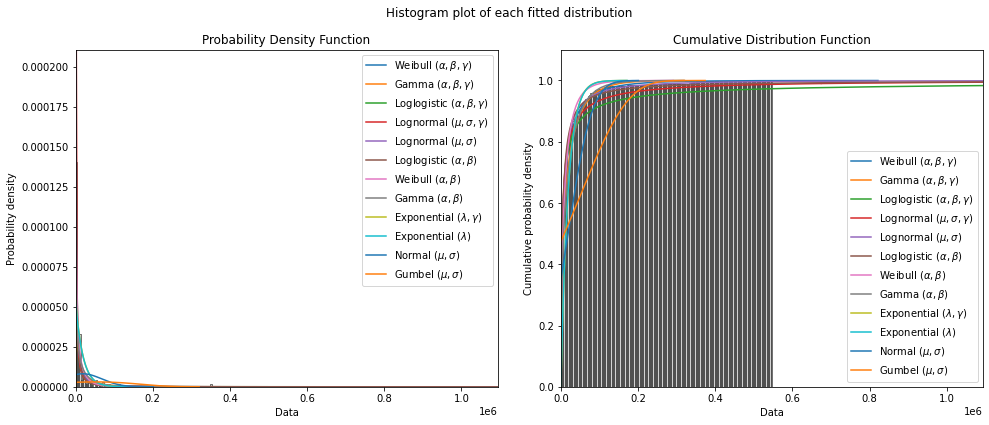

The best fitting distribution was Weibull_3P which had parameters [8.47335884e+03 4.85382713e-01 1.99999900e+02]
Kolmogorov-Smirnov statistic: 0.0885121412308808
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Lognormal Distribution (μ=8.3119,σ=1.8233)


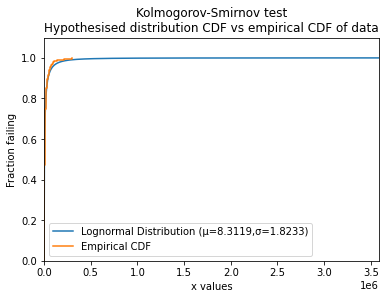

Kolmogorov-Smirnov statistic: 0.08741144356671907
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Weibull Distribution (α=9795.2228,β=0.6541)


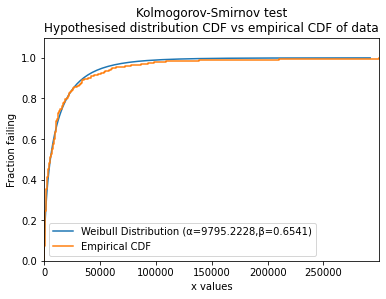

Kolmogorov-Smirnov statistic: 0.2699372318552606
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Exponential Distribution (λ=5.341e-05)


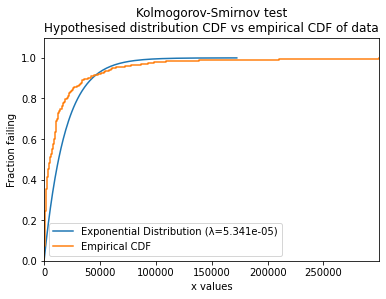

Type: master


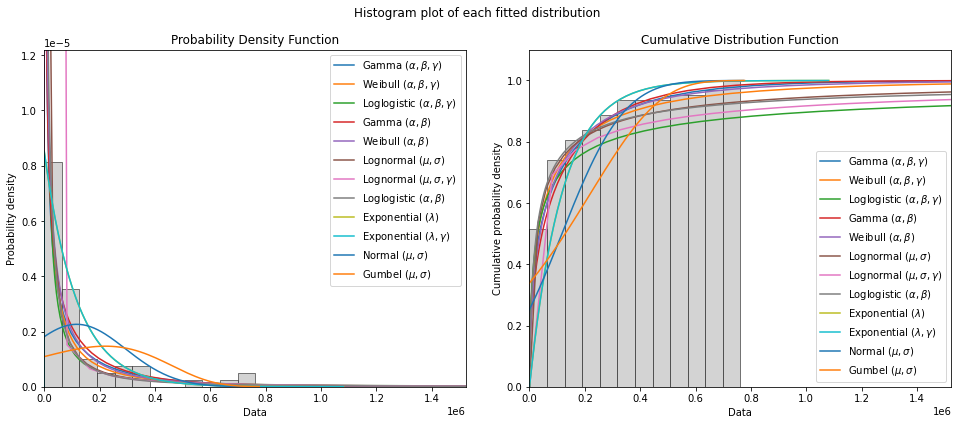

The best fitting distribution was Gamma_3P which had parameters [3.39904866e+05 3.45022346e-01 1.84999900e+02]
Kolmogorov-Smirnov statistic: 0.3503963553116124
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Lognormal Distribution (μ=10.1394,σ=2.2998)


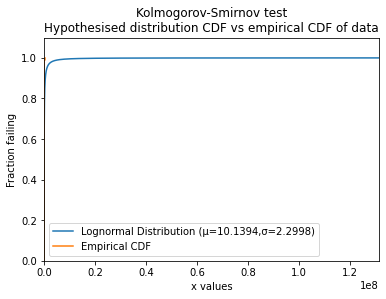

Kolmogorov-Smirnov statistic: 0.42877191400887893
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Weibull Distribution (α=74762.1984,β=0.5562)


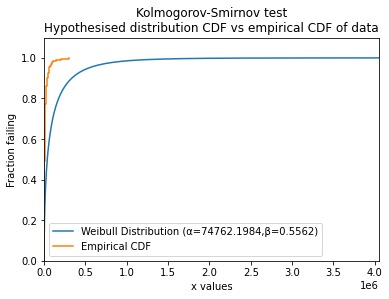

Kolmogorov-Smirnov statistic: 0.6558837187086521
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Exponential Distribution (λ=8.514e-06)


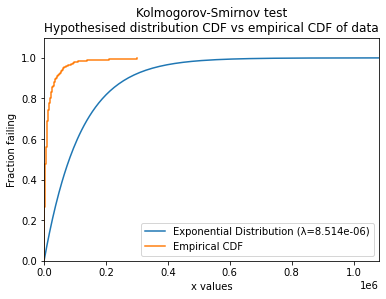

Type: storage


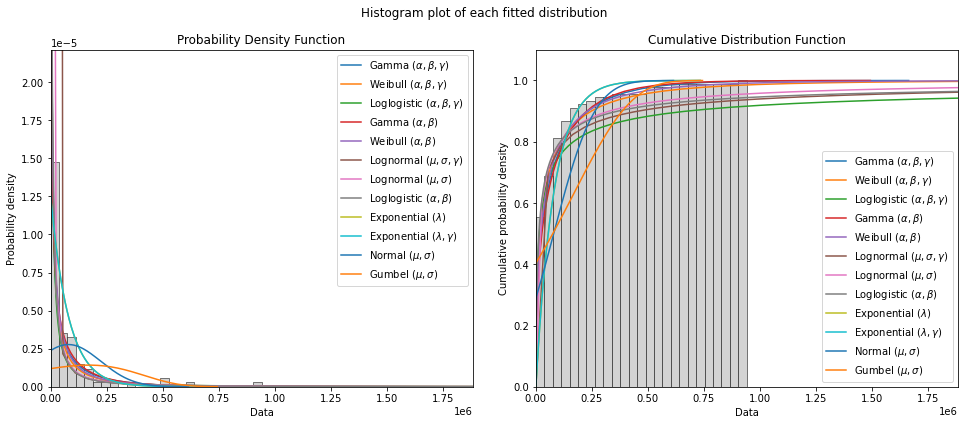

The best fitting distribution was Gamma_3P which had parameters [2.43786307e+05 3.26897268e-01 1.07999900e+02]
Kolmogorov-Smirnov statistic: 0.2510827144910712
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Lognormal Distribution (μ=9.5266,σ=2.4765)


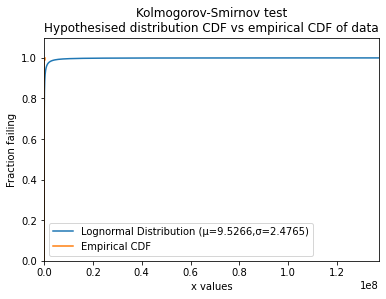

Kolmogorov-Smirnov statistic: 0.3247306575170248
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Weibull Distribution (α=44877.7787,β=0.5097)


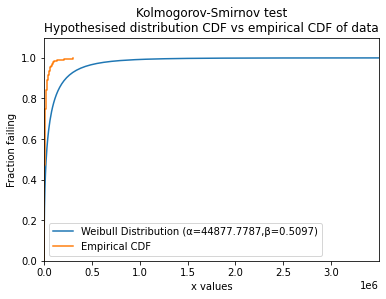

Kolmogorov-Smirnov statistic: 0.5833254411298872
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Exponential Distribution (λ=1.253e-05)


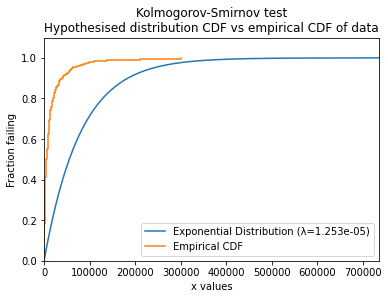

Type: login


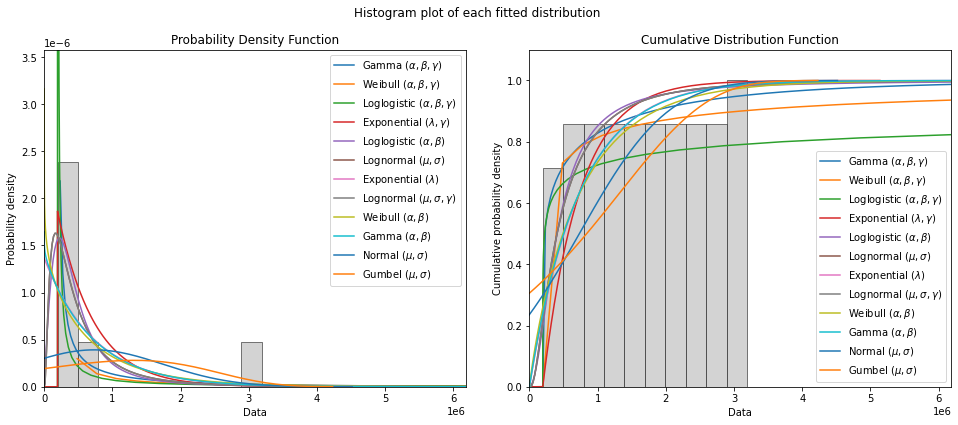

The best fitting distribution was Gamma_3P which had parameters [3.29605601e+06 1.62881377e-01 1.95077000e+05]
Kolmogorov-Smirnov statistic: 0.9278959546644331
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Lognormal Distribution (μ=12.9106,σ=0.94)


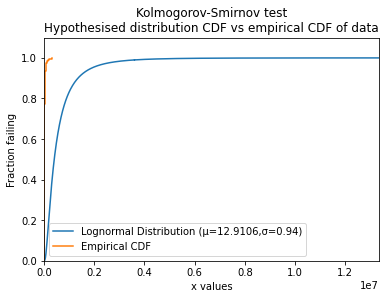

Kolmogorov-Smirnov statistic: 0.8500887857736233
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Weibull Distribution (α=735549.3992,β=0.9073)


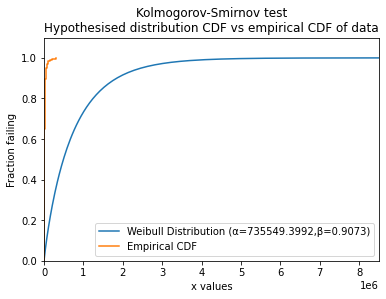

Kolmogorov-Smirnov statistic: 0.8694895511327337
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Exponential Distribution (λ=1.366e-06)


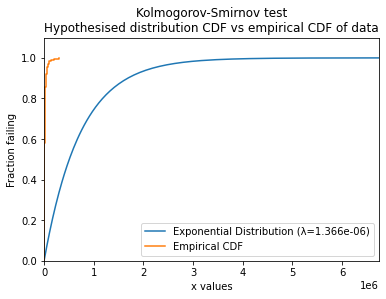

In [56]:
for t in types.index:
    print('Type:', t)
    data = dict_df_type_stat[t]['Interarrival'].dropna().to_numpy()
    
    try:
        results = Fit_Everything(failures=data, show_PP_plot = False, show_probability_plot = False, print_results = False, show_histogram_plot = True) 
        print('The best fitting distribution was', results.best_distribution_name, 'which had parameters', results.best_distribution.parameters)
    
        lognormal = Lognormal_Distribution(mu=results.results.loc['Lognormal_2P','Mu'], sigma=results.results.loc['Lognormal_2P','Sigma'])
        weibull = Weibull_Distribution(alpha=results.results.loc['Weibull_2P','Alpha'], beta=results.results.loc['Weibull_2P','Beta'])
        exponential = Exponential_Distribution(Lambda=results.results.loc['Exponential_1P','Lambda'])
        distributions = [lognormal, weibull, exponential]

        data = df_sys_stat['Interarrival'].to_numpy()

        for dist in distributions:
            result = KStest(distribution = dist, data = data, significance = 0.05)

    except Exception as e:
        print('Exception:', e)

### Empirical reliability

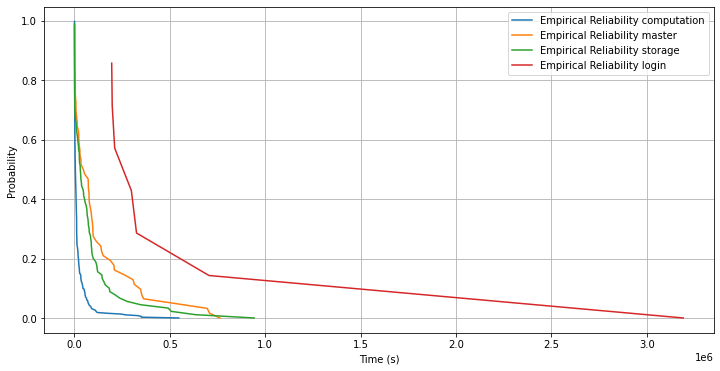

In [57]:
plt.figure(figsize=(12,6))
    
for t in types.index:
    ecdf = ECDF(dict_df_type_stat[t]['Interarrival'].dropna())

    plt.plot(ecdf.x, 1-ecdf.y, label = 'Empirical Reliability ' + str(t))

plt.xlabel('Time (s)')
plt.ylabel('Probability')
plt.legend()
plt.grid()
plt.savefig("./Images/Mercury/Mercury_Type_Emp_Reliability.svg", format = "svg")

# Top nodes

In [58]:
print('Number of nodes that generates error: ' + str(len(df_mercury['Node'].unique())))

Number of nodes that generates error: 53


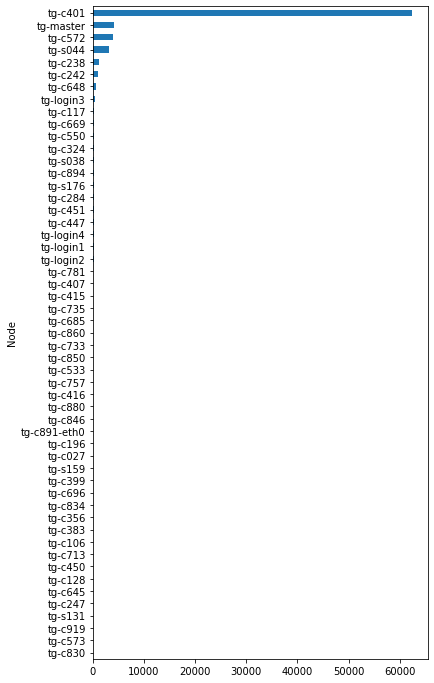

In [59]:
df_mercury.groupby(by='Node').Timestamp.count().sort_values().plot.barh(figsize=(6,12))
plt.show()

In [60]:
top_5 = df_mercury.groupby(by='Node').Timestamp.count().sort_values(ascending = False)[0:5]
top_5

Node
tg-c401      62340
tg-master     4098
tg-c572       4030
tg-s044       3224
tg-c238       1273
Name: Timestamp, dtype: int64

## Data Manipulation

### Temporal coalescence

#### Sensitivity analysis

In [61]:
c_wins = np.delete(np.arange(0,500,1), 0)

for node in top_5.index:
    df_temp = df_mercury.loc[df_mercury['Node'] == node]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = 'Dataset/Mercury/TopNodes/Mercury-' + node + '-Sensitivity.csv'
    sensitivity_analysis(df_temp, c_wins, filepath)

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!



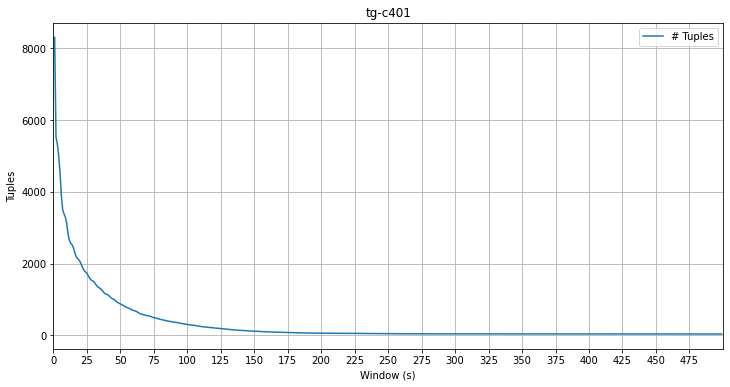

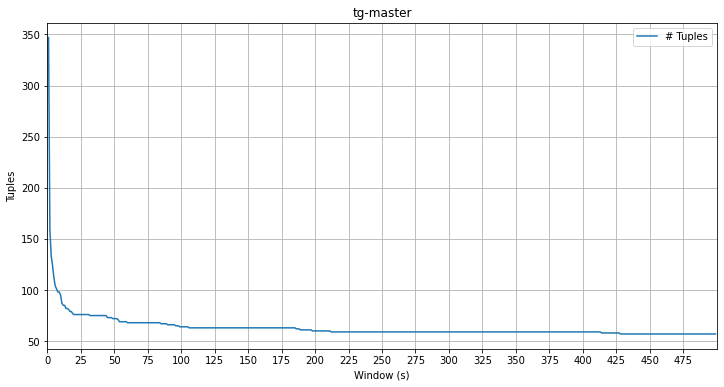

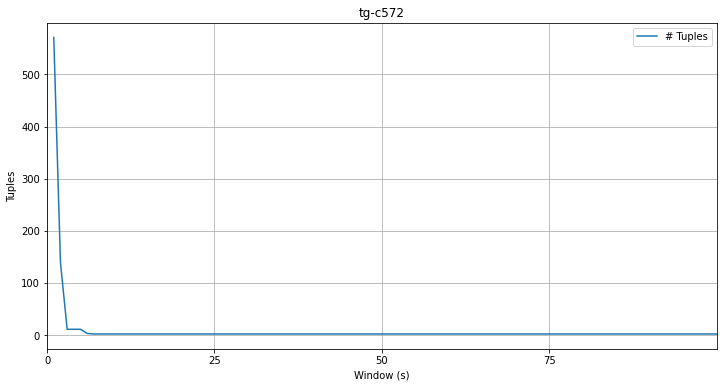

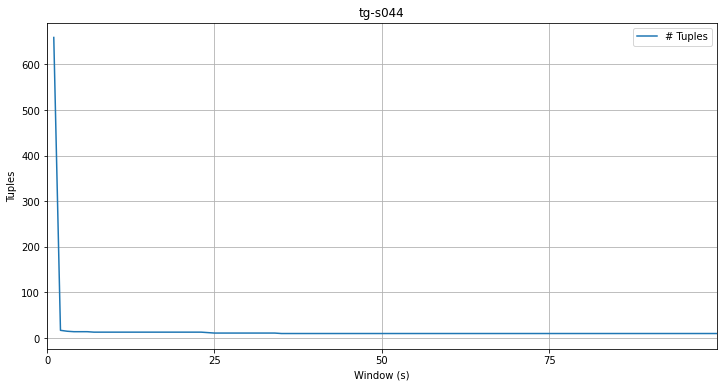

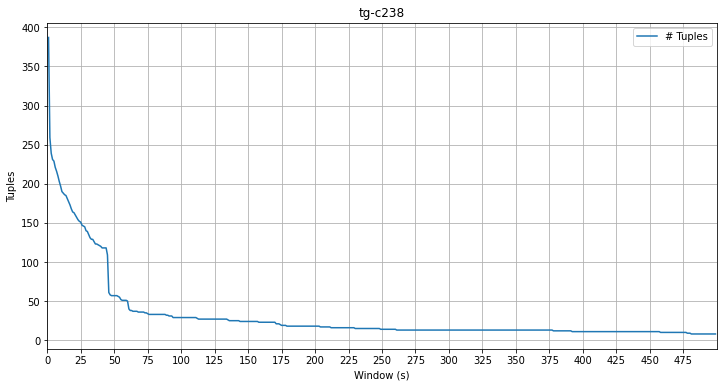

In [62]:
x_dict = {'tg-c401' : 500,
          'tg-master' : 500,
          'tg-c572' : 100,
          'tg-s044' : 100,
          'tg-c238' : 500}

for node in top_5.index:
    filepath = 'Dataset/Mercury/TopNodes/Mercury-' + node + '-Sensitivity.csv'
    
    df_temp_sensitivity = pd.read_csv(filepath, index_col = 0)
    
    x = df_temp_sensitivity['Window']
    y = df_temp_sensitivity['Tuples']
    
    plt.figure(figsize=(12,6))
    plt.plot(x, y, label = '# Tuples')
    plt.title(node)
    plt.xlim(0,x_dict[node])
    plt.xticks(np.arange(0, x_dict[node], step = 25))
    plt.xlabel('Window (s)')
    plt.ylabel('Tuples')
    plt.legend()
    plt.grid()
    plt.savefig("./Images/Mercury/Mercury_Top_Sensitivity_" + node + ".svg", format = "svg")

In [63]:
win_dict = {'tg-c401' : 200,
            'tg-master' : 200,
            'tg-c572' : 20,
            'tg-s044' : 30,
            'tg-c238' : 200}

print('Selected coalescence windows:', win_dict)

Selected coalescence windows: {'tg-c401': 200, 'tg-master': 200, 'tg-c572': 20, 'tg-s044': 30, 'tg-c238': 200}


#### Tupling

In [64]:
dict_df_node_stat = {}
dict_node_num_tup = {}

for node in top_5.index:
    df_temp = df_mercury.loc[df_mercury['Node'] == node]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = 'Dataset/Mercury/TopNodes/Mercury-' + node + '-Data.csv'
    
    df_tupling = tupling(df_temp, win_dict[node], filepath)
    num_tup = df_tupling.max(axis = 0).loc['Tuple'] + 1
    dict_node_num_tup[node] = num_tup
    
    df_stat = statistics(df_tupling)
    dict_df_node_stat[node] = df_stat
    
print('Number of tuples:', dict_node_num_tup)

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!

Number of tuples: {'tg-c401': 59, 'tg-master': 60, 'tg-c572': 2, 'tg-s044': 11, 'tg-c238': 18}


## Data Analysis

### Empirical time to failure distribution

Node: tg-c401


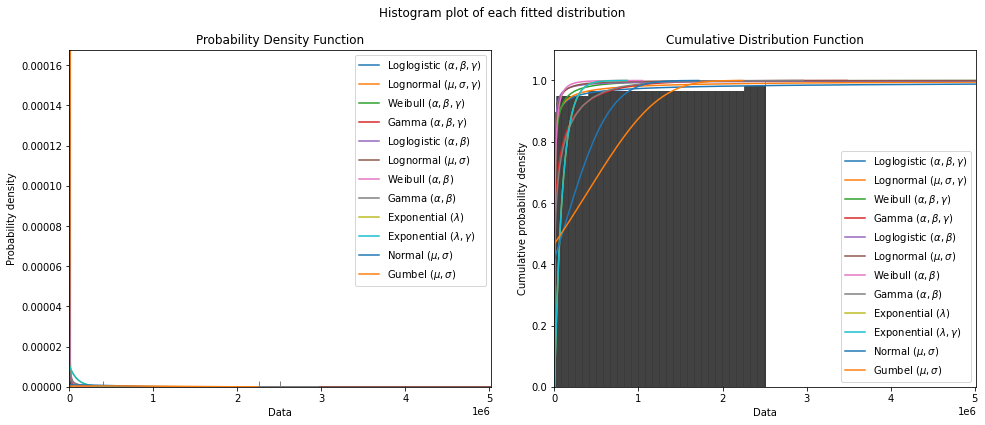

The best fitting distribution was Loglogistic_3P which had parameters [8.07878977e+02 5.06861718e-01 2.03999900e+02]
Kolmogorov-Smirnov statistic: 0.1953579221206899
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Lognormal Distribution (μ=7.604,σ=2.2596)


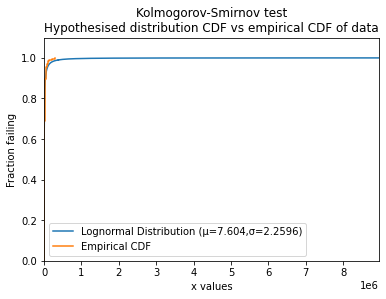

Kolmogorov-Smirnov statistic: 0.2029424934047884
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Weibull Distribution (α=7112.7844,β=0.4447)


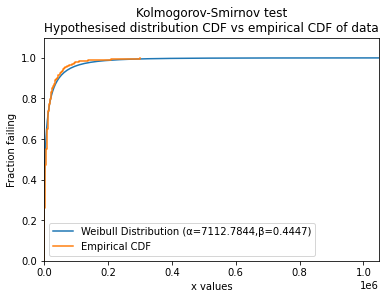

Kolmogorov-Smirnov statistic: 0.616320438003414
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Exponential Distribution (λ=1.066e-05)


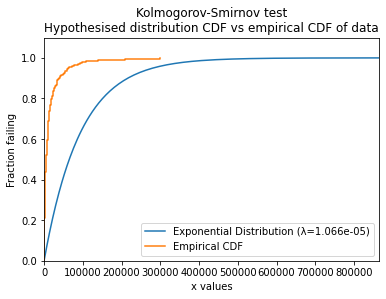

Node: tg-master


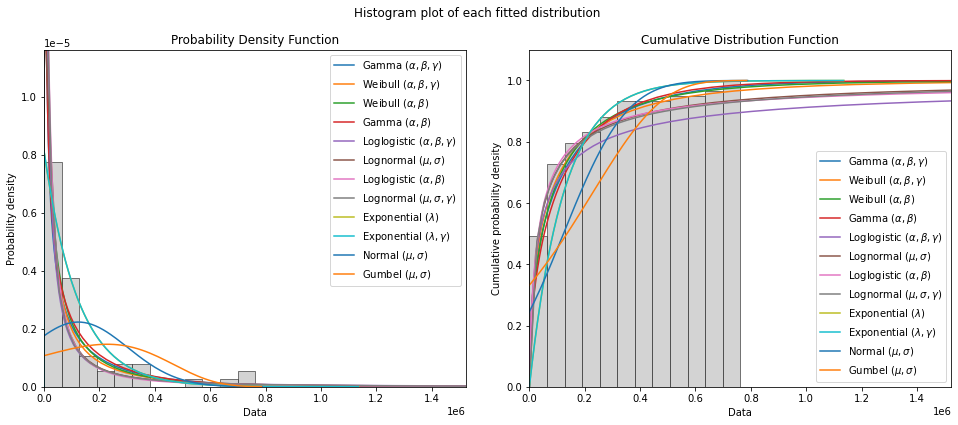

The best fitting distribution was Gamma_3P which had parameters [3.05994004e+05 4.02660321e-01 2.10999900e+02]
Kolmogorov-Smirnov statistic: 0.4029272804544486
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Lognormal Distribution (μ=10.3882,σ=2.0685)


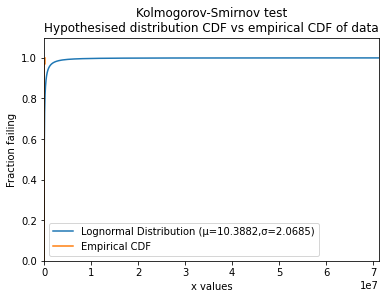

Kolmogorov-Smirnov statistic: 0.47087070309075474
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Weibull Distribution (α=85493.7312,β=0.6069)


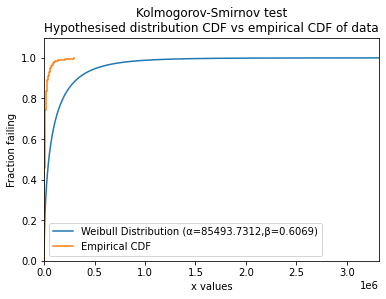

Kolmogorov-Smirnov statistic: 0.6636973691518101
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Exponential Distribution (λ=8.102e-06)


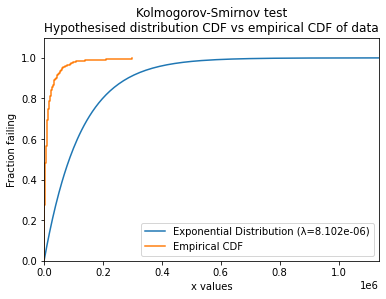

In [76]:
top_2 = [k for k in dict_node_num_tup if dict_node_num_tup[k] > 30]

for node in top_2:
    print('Node:', node)
    data = dict_df_node_stat[node]['Interarrival'].dropna().to_numpy()
    
    results = Fit_Everything(failures=data, show_PP_plot = False, show_probability_plot = False, print_results = False, show_histogram_plot = True) 
    print('The best fitting distribution was', results.best_distribution_name, 'which had parameters', results.best_distribution.parameters)
    
    lognormal = Lognormal_Distribution(mu=results.results.loc['Lognormal_2P','Mu'], sigma=results.results.loc['Lognormal_2P','Sigma'])
    weibull = Weibull_Distribution(alpha=results.results.loc['Weibull_2P','Alpha'], beta=results.results.loc['Weibull_2P','Beta'])
    exponential = Exponential_Distribution(Lambda=results.results.loc['Exponential_1P','Lambda'])
    distributions = [lognormal, weibull, exponential]

    data = df_sys_stat['Interarrival'].to_numpy()

    for dist in distributions:
        result = KStest(distribution = dist, data = data, significance = 0.05)
    
#     alpha = results.results.loc['Lognormal_3P','Gamma']
#     beta = results.results.loc['Lognormal_3P','Mu']
#     gamma = results.results.loc['Lognormal_3P','Sigma']
#     dist = Weibull_Distribution(alpha=alpha, beta=beta, gamma=gamma)

#     result = KStest(distribution = dist, data = dict_df_node_stat[node]['Interarrival'].dropna().to_numpy(), significance = 0.05)

### Empirical reliability

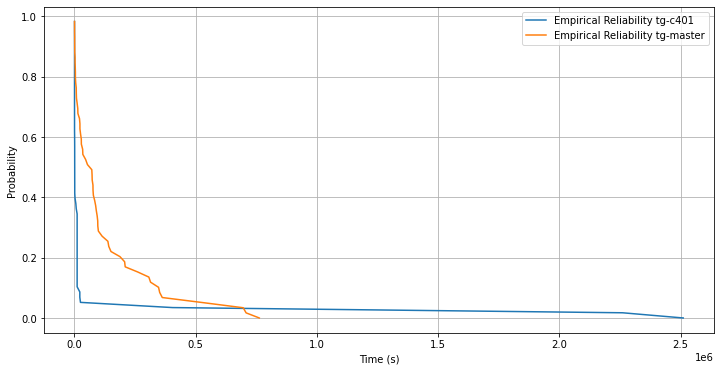

In [66]:
plt.figure(figsize=(12,6))
    
for node in top_2:
    ecdf = ECDF(dict_df_node_stat[node]['Interarrival'].dropna())

    plt.plot(ecdf.x, 1-ecdf.y, label = 'Empirical Reliability ' + str(node))

plt.xlabel('Time (s)')
plt.ylabel('Probability')
plt.legend()
plt.grid()
plt.savefig("./Images/Mercury/Mercury_Top_Emp_Reliability.svg", format = "svg")

tempo = pd.DataFrame(data = np.delete(ECDF(dict_df_node_stat['tg-c401']['Interarrival'].dropna()).x, 0), columns=['tempo'])
rel = pd.DataFrame(data = np.delete(ECDF(dict_df_node_stat['tg-c401']['Interarrival'].dropna()).y, 0), columns=['rel'])
tempo.to_csv('tempo.csv', index=False)
rel.to_csv('rel.csv', index=False)

# Bottleneck

## Data Manipulation

### Temporal coalescence

#### Sensitivity analysis

File already exists!



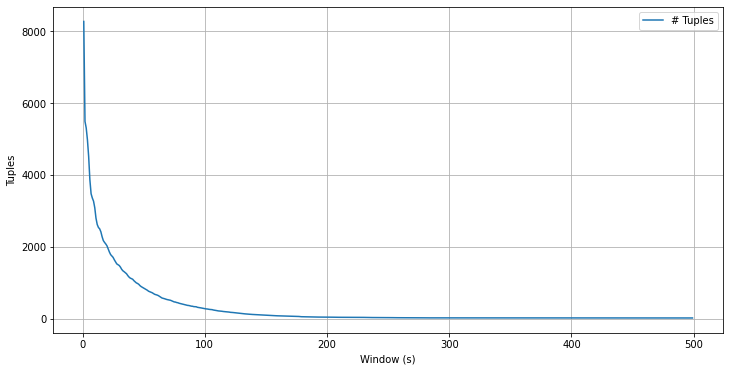

In [67]:
c_wins = np.delete(np.arange(0,500,1), 0)

filepath = 'Dataset/Mercury/Bottleneck/Mercury-bottleneck-Sensitivity.csv'

df_bottleneck.reset_index(drop = True, inplace = True)
df_bottleneck_sensitivity = sensitivity_analysis(df_bottleneck, c_wins, filepath)

plt.figure(figsize=(12,6))

plt.plot(df_bottleneck_sensitivity['Window'], df_bottleneck_sensitivity['Tuples'], label = '# Tuples')

plt.xlabel('Window (s)')
plt.ylabel('Tuples')
plt.legend()
plt.grid()
plt.savefig("./Images/Mercury/Mercury_Bottleneck_Sensitivity.svg", format = "svg")

#### Tupling

In [68]:
window = 200
filepath = 'Dataset/Mercury/Bottleneck/Mercury-bottleneck-Data.csv'

df_bottleneck = tupling(df_bottleneck, window, filepath)
df_bottleneck = df_bottleneck.astype({'Timestamp' : 'int32', 'Tuple' : 'int32'})
df_bottleneck.head()

File already exists!



,Timestamp,Node,Subsystem,Message,Tuple,Type
0,1171321113,tg-c401,DEV,+BEGIN HARDWARE ERROR STATE AT CPE,0,computation
1,1171321113,tg-c401,DEV,+Platform PCI Component Error Info Section,0,computation
2,1171321113,tg-c401,DEV,Component Info: Vendor Id =x x,0,computation
3,1171321156,tg-c401,DEV,+BEGIN HARDWARE ERROR STATE AT CPE,0,computation
4,1171321156,tg-c401,DEV,+Platform PCI Component Error Info Section,0,computation


In [69]:
num_tuple = df_bottleneck.max(axis = 0).loc['Tuple'] + 1
print('Number of tuples: ', num_tuple)

Number of tuples:  37


In [70]:
df_bottleneck_stat = statistics(df_bottleneck)
df_bottleneck_stat.head()

,# Entries,Start time,End time,Length,Density,Interarrival
Tuple,,,,,,
0,8569,1171321113,1171337216,16103,0.532137,NaN
1,9822,1171337536,1171356961,19425,0.505637,320.0
2,503,1171357195,1171358506,1311,0.383677,234.0
3,11,1171358737,1171358737,0,inf,231.0
4,1133,1171359013,1171360978,1965,0.576590,276.0


## Data Analysis 

### Empirical time to failure distribution

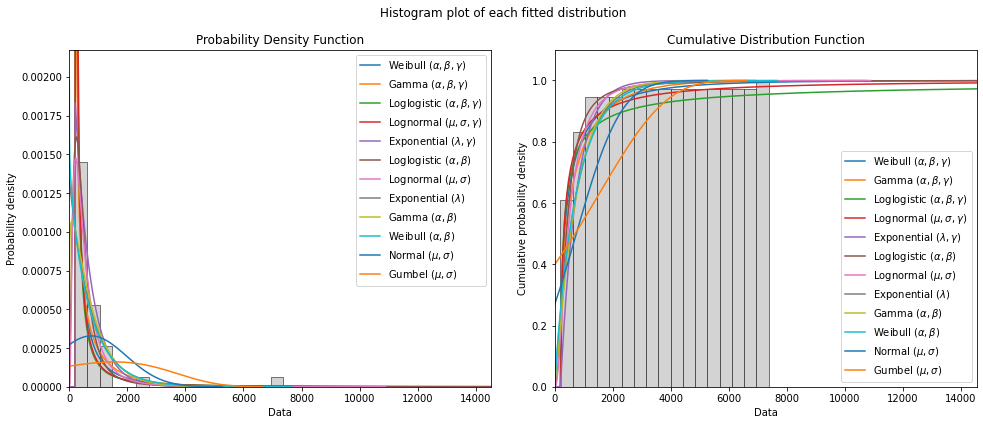

The best fitting distribution was Weibull_3P which had parameters [278.67054042   0.50538949 203.9999    ]
Kolmogorov-Smirnov statistic: 0.6429472656823365
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Lognormal Distribution (μ=6.1217,σ=0.8534)


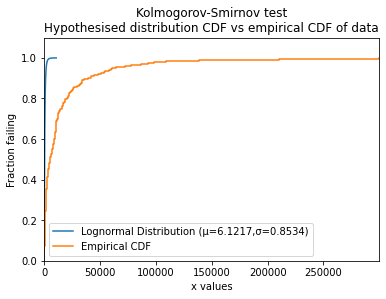

Kolmogorov-Smirnov statistic: 0.59091044252133
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Weibull Distribution (α=748.0197,β=0.9549)


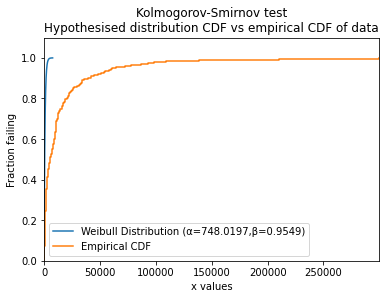

Kolmogorov-Smirnov statistic: 0.5985709021081955
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can REJECT the hypothesis that the data comes from a Exponential Distribution (λ=0.001333)


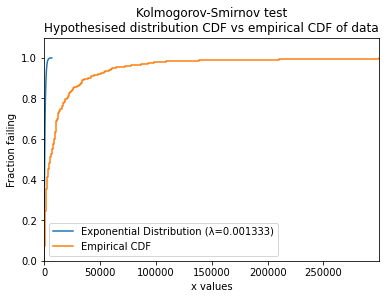

In [77]:
data = df_bottleneck_stat['Interarrival'].dropna().to_numpy()
   
results = Fit_Everything(failures=data, show_PP_plot = False, show_probability_plot = False, print_results = False, show_histogram_plot = True) 
print('The best fitting distribution was', results.best_distribution_name, 'which had parameters', results.best_distribution.parameters)

lognormal = Lognormal_Distribution(mu=results.results.loc['Lognormal_2P','Mu'], sigma=results.results.loc['Lognormal_2P','Sigma'])
weibull = Weibull_Distribution(alpha=results.results.loc['Weibull_2P','Alpha'], beta=results.results.loc['Weibull_2P','Beta'])
exponential = Exponential_Distribution(Lambda=results.results.loc['Exponential_1P','Lambda'])
distributions = [lognormal, weibull, exponential]

data = df_sys_stat['Interarrival'].to_numpy()

for dist in distributions:
    result = KStest(distribution = dist, data = data, significance = 0.05)

### Empirical reliability

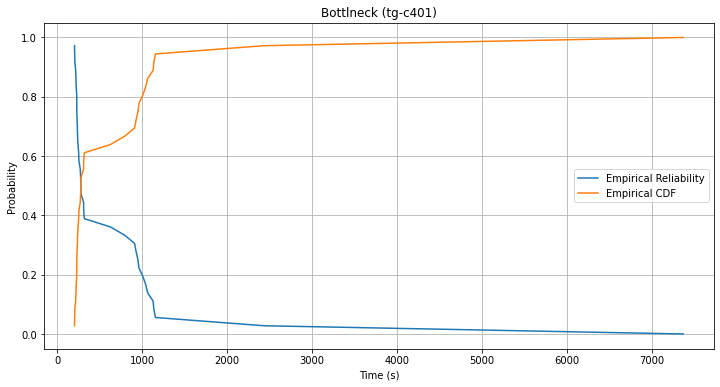

In [72]:
ecdf = ECDF(df_bottleneck_stat['Interarrival'].dropna())

plt.figure(figsize=(12,6))
plt.plot(ecdf.x, 1-ecdf.y, label = 'Empirical Reliability')
plt.plot(ecdf.x, ecdf.y, label = 'Empirical CDF')
plt.title('Bottlneck (tg-c401)')
plt.xlabel('Time (s)')
plt.ylabel('Probability')
plt.legend()
plt.grid()
plt.savefig("./Images/Mercury/Mercury_Bottleneck_Emp_Reliability.svg", format = "svg")

### General Analysis

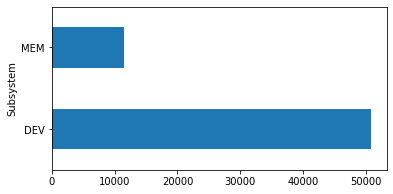

In [73]:
df_bottleneck.groupby(by='Subsystem').Timestamp.count().plot.barh(figsize=(6,3))

plt.savefig("./Images/Mercury/Mercury_Bottleneck_Bar_Subsystem.svg", format = "svg")
plt.show()

In [74]:
df_bottleneck_msg = df_bottleneck.groupby(by=['Subsystem','Message']).count().drop(columns=['Node', 'Type', 'Tuple'])

print(df_bottleneck_msg.to_latex())
df_bottleneck_msg

\begin{tabular}{llr}
\toprule
    &                    &  Timestamp \\
Subsystem & Message &            \\
\midrule
DEV & + Platform Specific Error Detail: &       5474 \\
    & +BEGIN HARDWARE ERROR STATE AT CPE &       6030 \\
    & +END HARDWARE ERROR STATE AT CPE &       3830 \\
    & +Platform PCI Component Error Info Section &       6805 \\
    & +Platform Specific Error Info Section &       5416 \\
    & Component Info: Vendor Id =x x &      23152 \\
MEM & + Mem Error Detail: &          4 \\
    & Physical Address x &      11552 \\
\bottomrule
\end{tabular}



Timestamp
Subsystem Message                                              
DEV       + Platform Specific Error Detail:                5474
          +BEGIN HARDWARE ERROR STATE AT CPE               6030
          +END HARDWARE ERROR STATE AT CPE                 3830
          +Platform PCI Component Error Info Section       6805
          +Platform Specific Error Info Section            5416
          Component Info: Vendor Id =x x                  23152
MEM       + Mem Error Detail:                                 4
          Physical Address x                              11552

In [75]:
# risolvere truncation e collision
# clustering